Benny Cohen

8/13/2020

DAV 6150 Final Project

### Abstract

It can be hard to judge how popular an article will be before publishing it. This is a problem for both the authors and publishers because both groups need to make a profit and increase their reputation. 

ICU published a dataset from Mashable, an entertainment website. The dataset contains information about the number of words in the title, the day the article was published, the number of key words, and the polarity of the title. 

In this notebook, we will perform eda and see how the various features in this dataset effect the number of shares an article will have. We then will prepare our data for model building and construct 5 different types of models, a GLM based model, a random forest, a neural net, an XGBoost regressor, and a stack ensemble model to predict the number of shares. 

At the end of the notebook, we will choose the model that performs the best. This model would be able to be used to predict the number of shares an article will have. From a practical perspective, this model would be able to be used by publishers to screen articles that won't do well and by authors to tweak their article to maximize the number of shares.

### Introduction

People write articles for a variety of reasons. Some people may find something interesting and want to share it, some may simply want to entertain, and others may be doing it for economic reasons. No matter the cause, people write articles so that people will read them. It is of interest then to structure articles to maximize the number of readers.

One metric to measure this is by counting the number of shares. Not only do shares indicate how popular an article is, search engines use the number of shares when ranking which results to display first. Having a model to predict the number of shares therefore, would be very useful.

The dataset we will look at is from Mashable, an entertainment company, and can be found at https://archive.ics.uci.edu/ml/datasets/Online+News+Popularity. The dataset contains information about the number of words in the title, the day the article was published, the number of key words in the title, and the polarity of different parts of the article. A model using these variables to predict the number of shares could be useful in figuring out good titles and times to publish an article. At the time of publishing the article, it could be hard to tell how popular the article will be. At the same time though, we would have access to almost all of the other features mentioned in the dataset. A model like this could help optimize what title the article should have, and what day the article should be released in order to maximize the number of shares.

Our main research question is 'How should an article be presented so as to maximize the number of shares'. In order to answer this question, we will first and foremost do eda on our dataset and see how our variables relate to the number of shares. We will then use our eda to prepare our data for various models. We will look at how different classes of models performs; a GLM based model, a random forest, a neural net, and an XGBoost regressor. For each of these models, we will optimize the hyper parameters. We also will create an ensemble model via stacking. 

To evaluate our models, we will look at various metrics like rmse, rmae, and the percent of values predicted within a certain amount of the true value. We also will create plots of our predictions. 

By the end of this project we will have a model that authors can use to maximize the number of shares. They will be able to feed metadata about their article to the model, as is in our dataset and iteratively change the features (such as giving the article a longer title or adding more keywords) to try to get more shares. Publishers will also be able to use this model to screen articles that won't be popular before publishing. 

### Exploratory Data Analysis

In [128]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [129]:
username = 'cohenb51'
path = 'Katz_School/master/DAV6150/OnlineNewsPopularity.csv'
df = pd.read_csv(f'https://raw.githubusercontent.com/{username}/{path}')

In [130]:
df.shape

(39644, 61)

Our data set is a good size. We have 61 columns and 39,000 + rows.

In [131]:
df.columns

Index(['url', ' timedelta', ' n_tokens_title', ' n_tokens_content',
       ' n_unique_tokens', ' n_non_stop_words', ' n_non_stop_unique_tokens',
       ' num_hrefs', ' num_self_hrefs', ' num_imgs', ' num_videos',
       ' average_token_length', ' num_keywords', ' data_channel_is_lifestyle',
       ' data_channel_is_entertainment', ' data_channel_is_bus',
       ' data_channel_is_socmed', ' data_channel_is_tech',
       ' data_channel_is_world', ' kw_min_min', ' kw_max_min', ' kw_avg_min',
       ' kw_min_max', ' kw_max_max', ' kw_avg_max', ' kw_min_avg',
       ' kw_max_avg', ' kw_avg_avg', ' self_reference_min_shares',
       ' self_reference_max_shares', ' self_reference_avg_sharess',
       ' weekday_is_monday', ' weekday_is_tuesday', ' weekday_is_wednesday',
       ' weekday_is_thursday', ' weekday_is_friday', ' weekday_is_saturday',
       ' weekday_is_sunday', ' is_weekend', ' LDA_00', ' LDA_01', ' LDA_02',
       ' LDA_03', ' LDA_04', ' global_subjectivity',
       ' global_sent

In [132]:
df.columns = df.columns.str.lstrip()

Let's start by looking at the distribution of our target variable, shares.

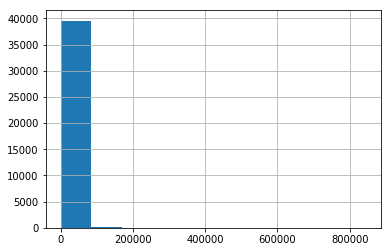

In [133]:
df.shares.hist()

This graph isn't very usable. It seems to be influenced by a small number of outliers which don't appear on the plot.

In [134]:
df.shares.max()

843300

In [135]:
print(f"The mean number of shares is {df.shares.mean()} and the std is {df.shares.std()}")

The mean number of shares is 3395.3801836343455 and the std is 11626.950748651716


In [136]:
def GetBasicInfo(col):
   print(f"The mean is {df[col].mean()} and the std is {df[col].std()}") 

Our mean is around 3,000 with a large std of around 11,626.950748651716. Let's make a plot of everything up to around this range then after look at the outliers.

In [137]:
cutoff = 3
notOutlierShares = df.shares[df.shares < df.shares.std() * cutoff]

In [138]:
print(f'{len(notOutlierShares)/len(df) * 100} percent of our data falls within {cutoff} deviations of our mean' )

99.11209766925639 percent of our data falls within 3 deviations of our mean


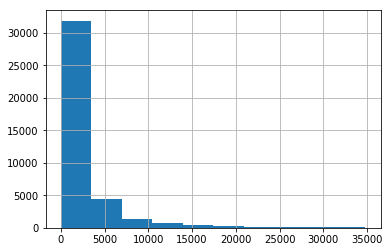

In [139]:
notOutlierShares.hist()

We see that within this range, our data is rightly skewed. Let's narrow this range down even more.

In [140]:
cutoff = 1
notOutlierShares = df.shares[df.shares < df.shares.std() * cutoff]
print(f'{len(notOutlierShares)/len(df) * 100} percent of our data falls within {cutoff} deviations of our mean' )

95.4520230047422 percent of our data falls within 1 deviations of our mean


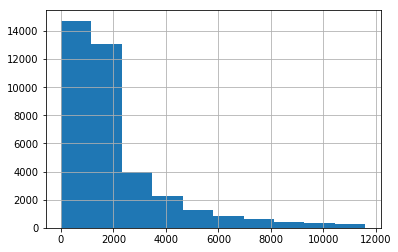

In [141]:
notOutlierShares.hist()

I think we have a good understanding of the type of distribution we have here. Our target variable is a count variable with a right skew. Over 95 percent of the data falls within 1 deviation of the mean. 

Based on this, it would not be appropriate to apply a linear model as this data won't fit a line. It my however fit a negative binomial distribution as the variance is clearly much greater than the mean.

In [142]:
df[df.shares == 0]

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,num_keywords,data_channel_is_lifestyle,data_channel_is_entertainment,data_channel_is_bus,data_channel_is_socmed,data_channel_is_tech,data_channel_is_world,kw_min_min,kw_max_min,kw_avg_min,kw_min_max,kw_max_max,kw_avg_max,kw_min_avg,kw_max_avg,kw_avg_avg,self_reference_min_shares,self_reference_max_shares,self_reference_avg_sharess,weekday_is_monday,weekday_is_tuesday,weekday_is_wednesday,weekday_is_thursday,weekday_is_friday,weekday_is_saturday,weekday_is_sunday,is_weekend,LDA_00,LDA_01,LDA_02,LDA_03,LDA_04,global_subjectivity,global_sentiment_polarity,global_rate_positive_words,global_rate_negative_words,rate_positive_words,rate_negative_words,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares


Another important piece is that no article has 0 shares. This isn't zero inflated.

In [143]:
df.shares.min()

1

In [144]:
df[df.shares == 1]

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,num_keywords,data_channel_is_lifestyle,data_channel_is_entertainment,data_channel_is_bus,data_channel_is_socmed,data_channel_is_tech,data_channel_is_world,kw_min_min,kw_max_min,kw_avg_min,kw_min_max,kw_max_max,kw_avg_max,kw_min_avg,kw_max_avg,kw_avg_avg,self_reference_min_shares,self_reference_max_shares,self_reference_avg_sharess,weekday_is_monday,weekday_is_tuesday,weekday_is_wednesday,weekday_is_thursday,weekday_is_friday,weekday_is_saturday,weekday_is_sunday,is_weekend,LDA_00,LDA_01,LDA_02,LDA_03,LDA_04,global_subjectivity,global_sentiment_polarity,global_rate_positive_words,global_rate_negative_words,rate_positive_words,rate_negative_words,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
17266,http://mashable.com/2013/12/09/wand-remote-con...,395.0,11.0,944.0,0.52164,1.0,0.66723,28.0,4.0,0.0,23.0,4.648305,10.0,0.0,0.0,1.0,0.0,0.0,0.0,-1.0,1400.0,342.555556,0.0,843300.0,421860.0,0.0,10480.0,5200.876648,2700.0,8100.0,5666.666667,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.322585,0.020003,0.02,0.417719,0.219693,0.552966,0.165502,0.049788,0.016949,0.746032,0.253968,0.400709,0.05,1.0,-0.299306,-0.6,-0.125,0.0,0.0,0.5,0.0,1


Only 1 article has 1 share. We see from this that most articles have at least a few shares.

Domain wise, this makes sense. Most articles that are published will have a few shares by the author and various other close people. Only a few, here we see the 1 percent, will gain a lot of traction. Once gained traction, the number of shares the article will get increases exponentially as each reader might choose to share it and increase the number of readers even more. That is why we have such a wide variance.

### Nulls.

In [145]:
df.isnull().sum().sum()

0

Our dataset has 0 nulls. 

In [146]:
df.columns

Index(['url', 'timedelta', 'n_tokens_title', 'n_tokens_content',
       'n_unique_tokens', 'n_non_stop_words', 'n_non_stop_unique_tokens',
       'num_hrefs', 'num_self_hrefs', 'num_imgs', 'num_videos',
       'average_token_length', 'num_keywords', 'data_channel_is_lifestyle',
       'data_channel_is_entertainment', 'data_channel_is_bus',
       'data_channel_is_socmed', 'data_channel_is_tech',
       'data_channel_is_world', 'kw_min_min', 'kw_max_min', 'kw_avg_min',
       'kw_min_max', 'kw_max_max', 'kw_avg_max', 'kw_min_avg', 'kw_max_avg',
       'kw_avg_avg', 'self_reference_min_shares', 'self_reference_max_shares',
       'self_reference_avg_sharess', 'weekday_is_monday', 'weekday_is_tuesday',
       'weekday_is_wednesday', 'weekday_is_thursday', 'weekday_is_friday',
       'weekday_is_saturday', 'weekday_is_sunday', 'is_weekend', 'LDA_00',
       'LDA_01', 'LDA_02', 'LDA_03', 'LDA_04', 'global_subjectivity',
       'global_sentiment_polarity', 'global_rate_positive_words',
     

Some columns don't help us at all.

1. timedelta - This gives the time between the time the article was published and the dataset was published. Nothing is predictive about this feature. 
2. url - This is just a string of where to find the article. It is basically a unique identifier that we can drop. 

In [147]:
df = df.drop(['timedelta', 'url'], axis = 1)

Now let's go through each of the features. Some of the features actually are related so let's put them in groups. 

### Category 1: Number of words. 
    
     1. n_tokens_title:                Number of words in the title
     2. n_tokens_content:              Number of words in the article
     3. n_unique_tokens:               Rate of unique words in the article
     4. n_non_stop_words:              Rate of non-stop words in the article
     5. n_non_stop_unique_tokens:      Rate of unique non-stop words in the
                                       content

In [148]:
numOfWordFeatures = ['n_tokens_title', 'n_tokens_content', 'n_unique_tokens', 'n_non_stop_words', 'n_non_stop_unique_tokens', 'shares']

In [149]:
numOfWordFeaturesDf = df[numOfWordFeatures]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000022F8BD9DB70>,
      dtype=object)

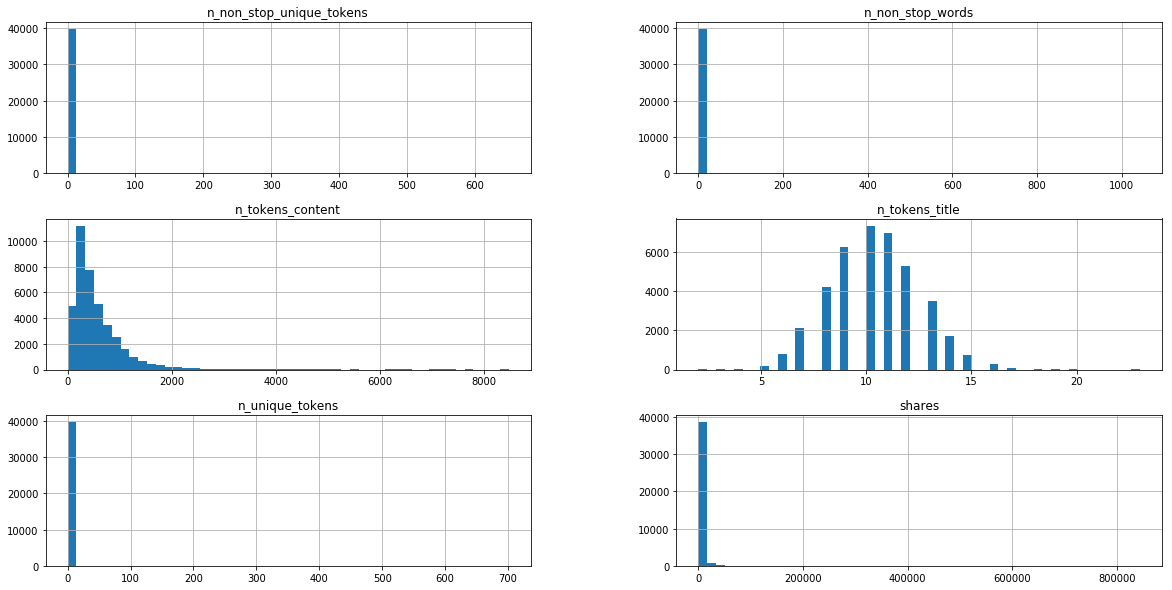

In [150]:
numOfWordFeaturesDf.hist(figsize=(20,10), bins = 50)

A lot of these graphs have outliers and it is making it harder to see the plots. We see that n_tokens_content is rightly skewed. The range of values also makes sense - Newspaper articles tend to be around 650 - 1500 words and as this is an entertainment site, people might expect articles to be a bit shorter. The longer tail makes sense as we would expect some authors to write more than others. The number of tokens_title seems to be normal.Let's look closer at the other columns as they seem to have outliers.

In [151]:
GetBasicInfo('n_unique_tokens')

The mean is 0.5482157168486088 and the std is 3.5207083312411243


It's odd that the mean would be so low, yet the graph is going all the way up to 600...

In [152]:
numOfWordFeaturesDf[numOfWordFeaturesDf.n_unique_tokens > 1]

,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,shares
31037,9.0,1570.0,701.0,1042.0,650.0,5900


We actually only have 1 row that is above 1. As this column is a rate between 0 and 1, this is clearly a data entry problem.
We have enough rows that dropping 1 row won't be a problem. At the same time, if we aren't going to use these columns there is no reason to drop it. Let's just keep this row in mind for later and drop it from our sub dataset and redraw the plots.

In [153]:
numOfWordFeaturesDf.drop(31037, axis = 0, inplace = True)

C:\Users\b-coh\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000022F8BC1E9E8>,
      dtype=object)

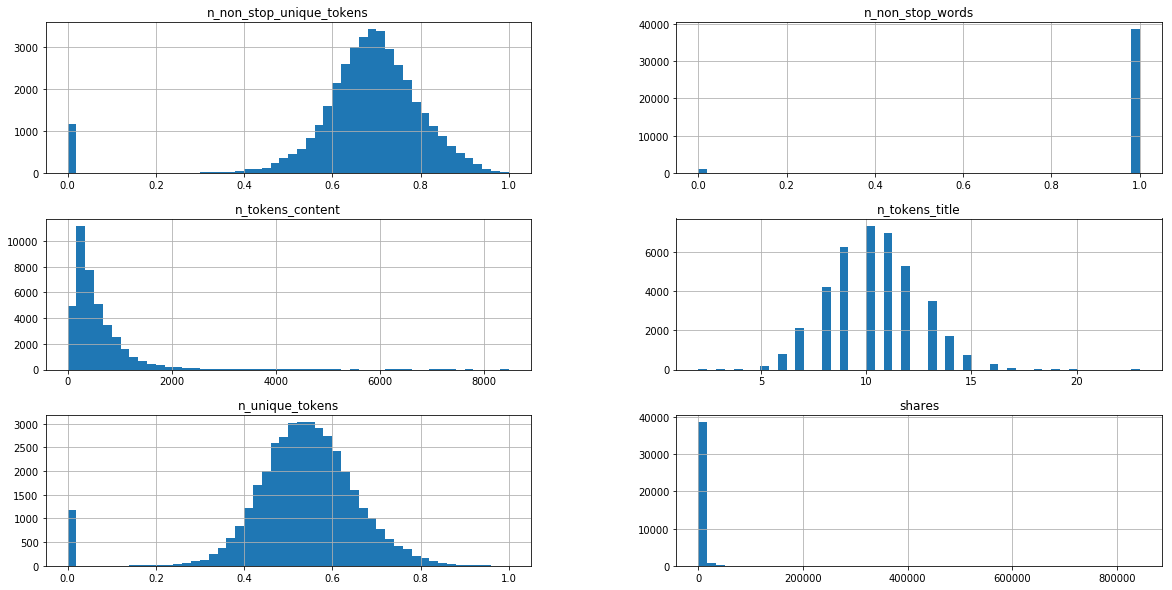

In [154]:
numOfWordFeaturesDf.hist(figsize=(20,10), bins = 50)

We see that The number of number of unique words is approximately normal and the number of of non stop unique words is also about normal. I'm finding it odd that we have rows where the number of unique words is 0. It seems like 0 is a filler for when the data wasn't collected.The n_non_stop_words seems to be very close to 1 for almost all entires.

In [155]:
numOfWordFeaturesDf.describe()

,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,shares
count,39643.000000,39643.000000,39643.000000,39643.000000,39643.000000,39643.000000
mean,10.398784,546.488914,0.530547,0.970209,0.672796,3395.317004
std,2.114052,471.085404,0.137112,0.170012,0.154035,11627.090592
min,2.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,9.000000,246.000000,0.470867,1.000000,0.625733,946.000000
50%,10.000000,409.000000,0.539216,1.000000,0.690476,1400.000000
75%,12.000000,716.000000,0.608696,1.000000,0.754624,2800.000000
max,23.000000,8474.000000,1.000000,1.000000,1.000000,843300.000000


In [156]:
df.n_non_stop_words.head()

0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: n_non_stop_words, dtype: float64

In [157]:
df.n_non_stop_words.mean()

0.9964685654578603

It seems like this column is almost all 1s. Also I don't really see why an article would be popular or not based on how many words it has. A stop word are words that are stripped in order to make searches faster. They shouldn't really effect how popular an article is. This column also has very little variance. For this reason I probably will drop this column later.

Let's look at the rows where the  number of unique tokens is 0. 

In [158]:
zeros = df[df.n_unique_tokens == 0]

In [159]:
len(zeros)

1181

In [160]:
pd.set_option('display.max_columns', None)

zeros.head(10)


,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,num_keywords,data_channel_is_lifestyle,data_channel_is_entertainment,data_channel_is_bus,data_channel_is_socmed,data_channel_is_tech,data_channel_is_world,kw_min_min,kw_max_min,kw_avg_min,kw_min_max,kw_max_max,kw_avg_max,kw_min_avg,kw_max_avg,kw_avg_avg,self_reference_min_shares,self_reference_max_shares,self_reference_avg_sharess,weekday_is_monday,weekday_is_tuesday,weekday_is_wednesday,weekday_is_thursday,weekday_is_friday,weekday_is_saturday,weekday_is_sunday,is_weekend,LDA_00,LDA_01,LDA_02,LDA_03,LDA_04,global_subjectivity,global_sentiment_polarity,global_rate_positive_words,global_rate_negative_words,rate_positive_words,rate_negative_words,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
893,10.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,217.0,1200.0,542.500000,0.0,51900.0,16928.571429,0.000000,3647.272727,1923.430603,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.191383,0.028703,0.179282,0.572047,0.028586,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.550000,-0.500000,0.050000,0.500000,2500
917,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,1.0,0.0,0.0,0.0,0.0,0.0,217.0,2000.0,582.285714,0.0,51900.0,16080.000000,0.000000,2939.239130,1596.149445,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.020362,0.133522,0.020019,0.020554,0.805543,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.500000,0.000000,1700
1062,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,1.0,0.0,217.0,2500.0,669.000000,0.0,51900.0,17255.555556,0.000000,4380.000000,2328.023284,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.532843,0.022387,0.260606,0.023187,0.160977,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.500000,0.000000,4500
1121,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,1.0,0.0,0.0,0.0,217.0,1700.0,611.000000,0.0,51900.0,13628.571429,0.000000,4408.000000,2332.097082,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.885229,0.028718,0.028587,0.028866,0.028599,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.066667,0.033333,0.433333,0.033333,6800
1312,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,1.0,0.0,0.0,0.0,0.0,217.0,1700.0,517.800000,440.0,51900.0,17628.000000,440.000000,4423.333333,2305.412167,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.020977,0.020356,0.020075,0.918569,0.020023,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.283333,0.266667,0.216667,0.266667,1000
1336,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,8.0,0.0,0.0,0.0,0.0,1.0,0.0,217.0,1700.0,600.750000,1200.0,51900.0,19812.500000,832.400000,3875.000000,2336.914142,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.026198,0.025842,0.025072,0.026979,0.895910,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.500000,0.136364,0.000000,0.136364,1800
1352,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,1.0,217.0,1700.0,532.000000,0.0,51900.0,22380.000000,0.000000,4555.000000,2882.018787,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.622872,0.020124,0.316661,0.020258,0.020085,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.500000,0.000000,1200
1454,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,1.0,0.0,0.0,0.0,0.0,217.0,2100.0,642.900000,2100.0,69100.0,27050.000000,1712.394737,3809.000000,2895.485104,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.668097,0.271192,0.020081,0.020553,0.020077,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.433333,0.066667,0.066667,0.066667,2100
1485,12.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,217.0,1000.0,444.400000,0.0,69100.0,22366.666667,0.000000,3086.636364,2242.897864,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.033448,0.033449,0.033334,0.866422,0.033347,0.0,0.0,0.0,0.0,0.0,0

One thing that I am noticing about these rows is that they all zeros for several of the other rows.

In [161]:
zeros.max()

n_tokens_title                       17.000000
n_tokens_content                      0.000000
n_unique_tokens                       0.000000
n_non_stop_words                      0.000000
n_non_stop_unique_tokens              0.000000
num_hrefs                             0.000000
num_self_hrefs                        0.000000
num_imgs                            100.000000
num_videos                           24.000000
average_token_length                  0.000000
num_keywords                         10.000000
data_channel_is_lifestyle             1.000000
data_channel_is_entertainment         1.000000
data_channel_is_bus                   1.000000
data_channel_is_socmed                1.000000
data_channel_is_tech                  1.000000
data_channel_is_world                 1.000000
kw_min_min                          217.000000
kw_max_min                        59100.000000
kw_avg_min                         8483.941429
kw_min_max                       843300.000000
kw_max_max   

In [162]:
df.mean()

n_tokens_title                       10.398749
n_tokens_content                    546.514731
n_unique_tokens                       0.548216
n_non_stop_words                      0.996469
n_non_stop_unique_tokens              0.689175
num_hrefs                            10.883690
num_self_hrefs                        3.293638
num_imgs                              4.544143
num_videos                            1.249874
average_token_length                  4.548239
num_keywords                          7.223767
data_channel_is_lifestyle             0.052946
data_channel_is_entertainment         0.178009
data_channel_is_bus                   0.157855
data_channel_is_socmed                0.058597
data_channel_is_tech                  0.185299
data_channel_is_world                 0.212567
kw_min_min                           26.106801
kw_max_min                         1153.951682
kw_avg_min                          312.366967
kw_min_max                        13612.354102
kw_max_max   

In the first group I took the max of the values. In the second I took the mean. Comparing these 2, we notice that all the attributes that involve predicting something about the words, (Ex - rate_negative_words) are 0. It seems from this simply that no info about the number of words was collected for these rows. This might not actually be a data collection problem but just that these were articles with unique content like graphs or videos without so many words. We therefore can't really drop these rows. Models like random forest may be robust enough to deal with these rows.  

Now we should look at correlations with our shares variable,

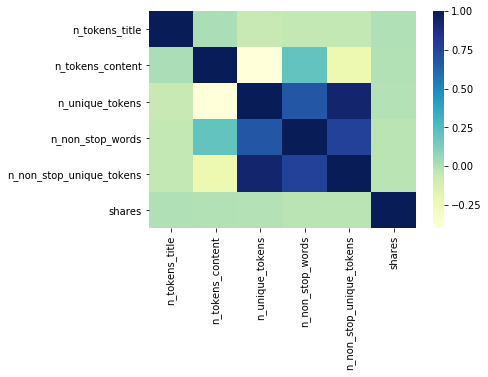

In [163]:
import seaborn as sns
corr = numOfWordFeaturesDf.corr()

sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        cmap="YlGnBu")

We see heavy correlations between some some of our variables like number of unique tokens and number of unique stop words. This makes sense as they both measure unique words. The relationship with our target variable seems small though.

In [164]:
corr.shares

n_tokens_title              0.008787
n_tokens_content            0.002447
n_unique_tokens            -0.007055
n_non_stop_words           -0.019644
n_non_stop_unique_tokens   -0.020487
shares                      1.000000
Name: shares, dtype: float64

All of these correlations are around 0. We still might be able to get some insight with these variables combined with other features. Because of this, I am hesitant to flat out drop them.

#### Category 2 LDA

1. LDA_00:                        Closeness to LDA topic 0
2. LDA_01:                        Closeness to LDA topic 1
3. LDA_02:                        Closeness to LDA topic 2
4. LDA_03:                        Closeness to LDA topic 3
5. LDA_04:                        Closeness to LDA topic 4

This feature was actually created by another machine learning model called Latent Dirichlet Allocation https://medium.com/@lettier/how-does-lda-work-ill-explain-using-emoji-108abf40fa7d

As we see from the paper which created this dataset, http://repositorium.sdum.uminho.pt/bitstream/1822/39169/1/main.pdf, this algorithm was used to 

1. Identify the top 5 most popular categories articles were written in. This is unsupervised clustering.
2. See how close each article is to the top 5 articles. 

This algorithm is a distance based algorithm. 

Inutitivly, we would think articles which are close to popular categories would have more shares. Let's see if this is true.

In [165]:
ldaDf = df[['LDA_00','LDA_01', 'LDA_02', 'LDA_03', 'LDA_04', 'shares']]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000022F8DDA6668>,
      dtype=object)

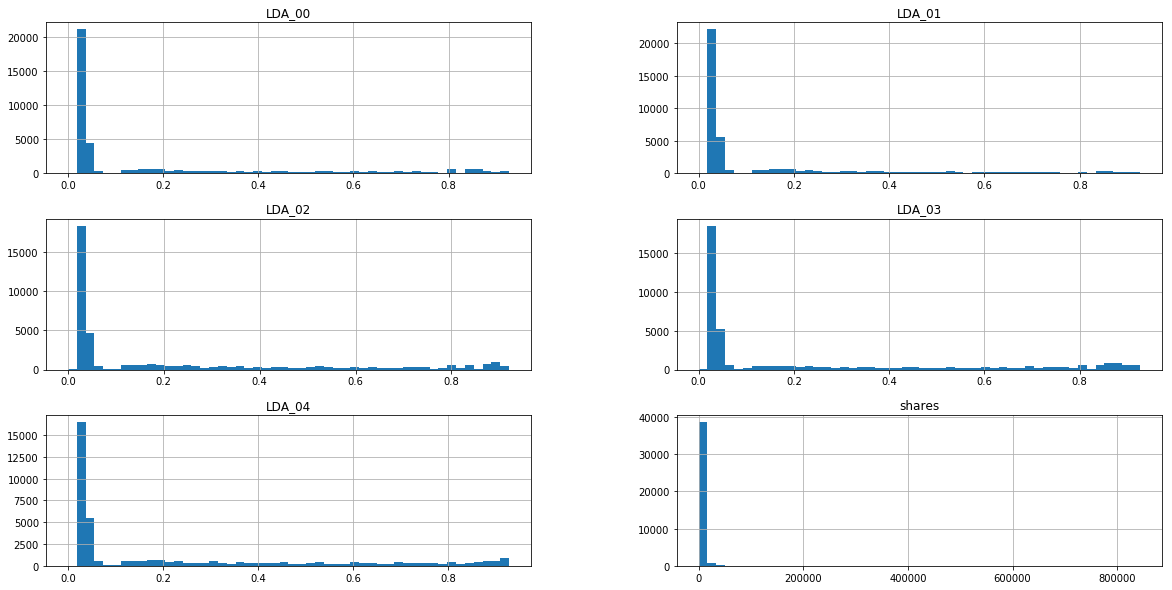

In [166]:
ldaDf.hist(figsize=(20,10), bins = 50)

These varibles are all rightly skewed and on a scale from 0 to 1.This is expected, most articles will fit only with 1 or 2 categories.

Now let's check if any of these are correlated.

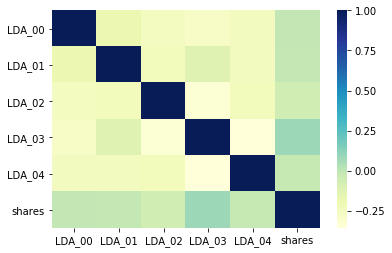

In [167]:
import seaborn as sns
corr = ldaDf.corr()

sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        cmap="YlGnBu")

We see some small negative correlations between the lda columns. The relationships with the number of shares seems close to 0.

In [168]:
corr.shares

LDA_00   -0.003793
LDA_01   -0.010183
LDA_02   -0.059163
LDA_03    0.083771
LDA_04   -0.016622
shares    1.000000
Name: shares, dtype: float64

In [169]:
corr.LDA_00

LDA_00    1.000000
LDA_01   -0.179342
LDA_02   -0.255555
LDA_03   -0.274588
LDA_04   -0.243426
shares   -0.003793
Name: LDA_00, dtype: float64

These correlations between the lda columns are negative and although small it is unlikely that this occured due to chance. It makes sense that the relationship is negative because if a value is closely connected to 1 category it's less likely to be close to the other categories. 

Let's look at this data a bit closer. We might really only care about the rows where we have a high match between some of the categories. (say LDA > .5)

In [170]:
highLda3 = df[df.LDA_03 > .5]

In [171]:
len(highLda3)

8264

In [172]:
highLda3.shares.mean()

5126.261616650532

In [173]:
df.shares.mean()

3395.3801836343455

Notice how the number of shares increases when the lda is higher.

Let's see if this is true with the other lda columns.

In [174]:
highLda2 = df[df.LDA_02 > .5]
len(highLda2)
highLda2.shares.mean()

2093.9815363881403

With lda being 2 the value actually decreases.

In [175]:
highLda1 = df[df.LDA_01 > .5]
highLda1.shares.mean()

2994.953488372093

With 1 it is around the average.

In [176]:
highLda0 = df[df.LDA_00 > .5]
highLda0.shares.mean()

3327.0480738102947

With 0 it is around average.

In [177]:
highLda4 = df[df.LDA_04 > .5]
highLda4.shares.mean()

3069.2084493402735

With 4 it is around average.

The only ones where we saw significant differences is with lda 3 and lda 2. With lda 3 we saw high ldas have about 1000 more shares ad with lda 2 we saw high ldas have about 1000 less shares.

A difference of 1000 is significant given the size of our dataset. That being said, we did see earlier that some of our shares have a large variance.

In [178]:
highLda3.shares.std()

17279.15907415944

In [179]:
highLda2.shares.std()

5031.717987471148

In [180]:
df.shares.std()

11626.950748651716

The variance for the rows with high lda2 are lower but for 3 they are higher, both by around 5000. To get a better look we need to plot the distribution.

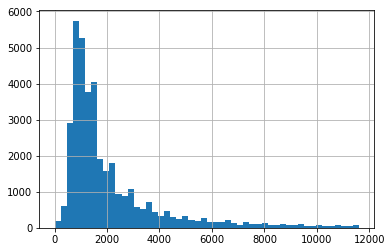

In [181]:
cutoff = 1
notOutlierShares = df.shares[df.shares < df.shares.std() * cutoff]
notOutlierShares.hist(bins = 50)

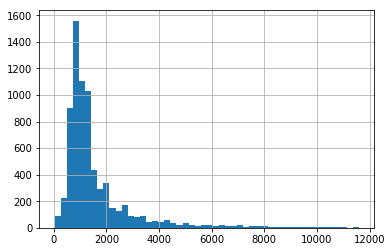

In [182]:
notOutlierShares = highLda2.shares[df.shares < df.shares.std() * cutoff]
notOutlierShares.hist(bins = 50)

Overall the distribution seems to be following the same shape. There are slight fluctuations around where the peak is but it doesn't seem so different.

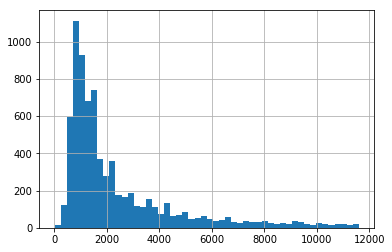

In [183]:
notOutlierShares = highLda3.shares[df.shares < df.shares.std() * cutoff]
notOutlierShares.hist(bins = 50)

The shape of the distribution for high lda 3 looks around the same too.

This, along with our low r2 score makes it seem like this group of features isn't going to be so predictive for us.

#### Category 3 Weekday Columns

In [184]:
weekdays = df[['weekday_is_monday', 'weekday_is_tuesday', 'weekday_is_wednesday', 'weekday_is_thursday', 'weekday_is_friday',
       'weekday_is_saturday', 'weekday_is_sunday']]

In [185]:
weekdays.sum()

weekday_is_monday       6661.0
weekday_is_tuesday      7390.0
weekday_is_wednesday    7435.0
weekday_is_thursday     7267.0
weekday_is_friday       5701.0
weekday_is_saturday     2453.0
weekday_is_sunday       2737.0
dtype: float64

We see that most of our data points are coming from articles on wendsday. A lot fewer are coming from Saturday and Sunday which is interesting since I would think that more articles would be written then since people would have more time to read them. At the same time, it also may be an off day for writers. 

Let's see how these variables relate to the number of shares.

In [186]:
for i in weekdays.columns:
    print(f'The mean for shares on {i} is {df[df[i] == 1].shares.mean()}')


The mean for shares on weekday_is_monday is 3647.0258219486564
The mean for shares on weekday_is_tuesday is 3202.5006765899866
The mean for shares on weekday_is_wednesday is 3303.4053799596504
The mean for shares on weekday_is_thursday is 3178.5991468281272
The mean for shares on weekday_is_friday is 3285.181020873531
The mean for shares on weekday_is_saturday is 4078.1850794944967
The mean for shares on weekday_is_sunday is 3746.7405918889294


<BarContainer object of 7 artists>

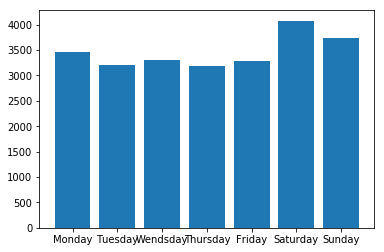

In [187]:
x = ['Monday', 'Tuesday', 'Wendsday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
y = [3467, 3202, 3303, 3178, 3285, 4078, 3746]

plt.bar(x,y)

In [188]:
df.shares.mean()

3395.3801836343455

We see that Saturday and Sunday have the total highest number of shares. This is no surprise as these days are on the weekend. Monday also performs similar to Sunday with around 3650 shares.

Thursday seems to be the day when people do the least amount of sharing.

#### Category 4: Topic Columns

In [189]:
topics = df[['data_channel_is_lifestyle',
       'data_channel_is_entertainment', 'data_channel_is_bus',
       'data_channel_is_socmed', 'data_channel_is_tech']]

In [190]:
for i in topics.columns:
    print(f'The mean for shares on {i} is {df[df[i] == 1].shares.mean()}')

The mean for shares on data_channel_is_lifestyle is 3682.123392091472
The mean for shares on data_channel_is_entertainment is 2970.487034150489
The mean for shares on data_channel_is_bus is 3063.0185362735697
The mean for shares on data_channel_is_socmed is 3629.383125269049
The mean for shares on data_channel_is_tech is 3072.283283419548


Lifestyle articles do the best. Entertainment articles surprisingly have the least number of shares. I would have thought that those would do better on an entertainment website.

In [191]:
counts = df.groupby('num_keywords')['shares'].mean()
counts

num_keywords
1.0     1664.313725
2.0     1941.422222
3.0     2532.198425
4.0     2478.099712
5.0     3010.248913
6.0     3490.664314
7.0     3534.816853
8.0     3551.162291
9.0     3619.011623
10.0    3561.052326
Name: shares, dtype: float64

Here we notice a very big relationship. The more key words, the more shares.

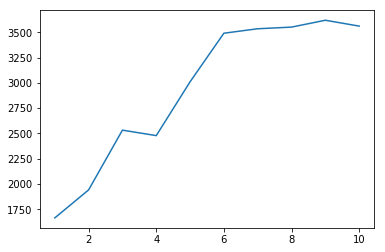

In [192]:
plt.plot(counts.index, counts.values) 

X axis has the number of keywords. Y axis has the number of avg shares for that group. This curve seems to be about linear but tails off like logistic regression. Naturally, key words can help a lot at the start but won't help that much past a point.

#### Category 5: Sentiment

In [193]:
sentiment = df[['global_subjectivity',
       'global_sentiment_polarity', 'global_rate_positive_words',
       'global_rate_negative_words', 'rate_positive_words',
       'rate_negative_words', 'avg_positive_polarity', 'avg_negative_polarity', 'title_subjectivity',
       'title_sentiment_polarity', 'shares']]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000022F8EB61128>,
      dtype=object)

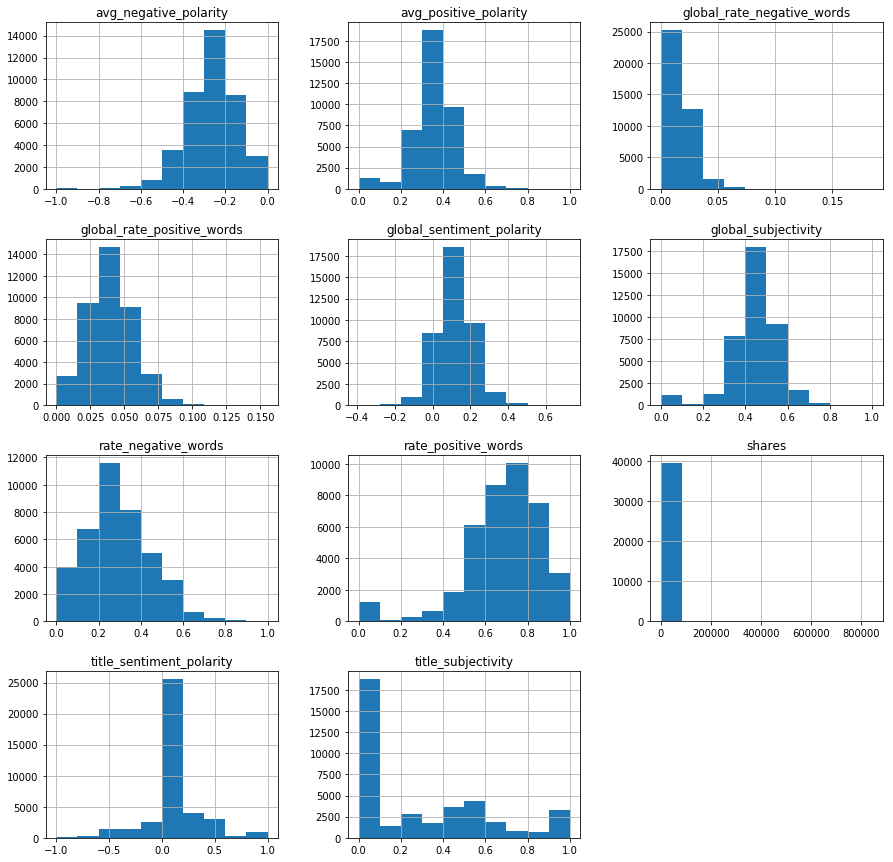

In [194]:
sentiment.hist(figsize = (15,15))

Most of these curves seem approximately normal. The exception to this is title subjectivity which has a lot of values close to 0. 

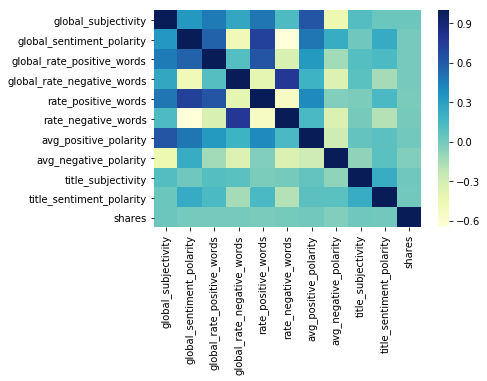

In [195]:
import seaborn as sns
corr = sentiment.corr()

sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        cmap="YlGnBu")

We see that a lot of these variables are heavily correlated. This is natural since some of these columns were used as inputs to a model to extract these values. The global rate variables are inherently correlated to the rate columns (ex - rate_negative words and global_rate_negative_words. We will drop some of these columns as they are collinear.  

Some of these variables are on a scale of 0 to 1 and others are on a scale of -1 to 1. The ones that are on a scale of -1 to 1 we also have a column with the absolute value. The variables expressing a rate, ex - global rate of positive words are a percentage of the total number of words in the article. 

Most of these columns are normal. The exceptions are title subjectivity - it seems like most articles are not subjective. 

Also, there seems to be very low correlation between these columns and the number of shares. We should question including them in our models.

None of these variables seem particularly related to shares as they are all around 0... I'm slightly surprised by this since I would have thought the tone of an article would effect viewership. It could be that the tone could effect viewership positively or negatively and it balances out, but I can't say for certain.

We have a few more columns still to look at...

#### Category 6: Miscellaneous

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000022F88238240>]],
      dtype=object)

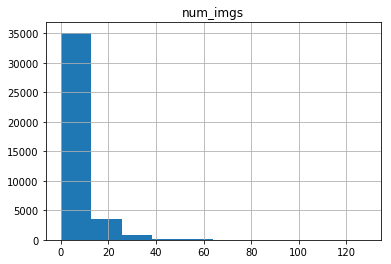

In [196]:
df[['num_imgs']].hist()

The number of imgs is rightly skewed...

In [197]:
subset = df[df['num_imgs'] < 30]

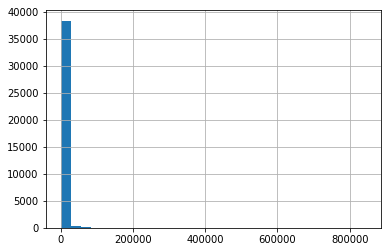

In [198]:
subset.shares.hist(bins = 30)

This graph isn't so helpful because we have so many outliers. We will look at a correlation coef. below.

In [199]:
subset.shares.mean()

3389.4972022382094

In [200]:
subset = df[df['num_imgs'] <= 5]

In [201]:
len(subset)

30440

It seems like posts with images have more shares. Let's see if the same is true with videos.

In [202]:
subset = df[df['num_videos'] >5]

In [203]:
subset.shares.mean()

4550.916543209876

In [204]:
subset = df[df['num_videos'] < 5]

In [205]:
subset.shares.mean()

3332.8154523618896

We notice the same trend here with number of videos. 

Let's look at the number of hrefs, links,

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000022F902B16D8>]],
      dtype=object)

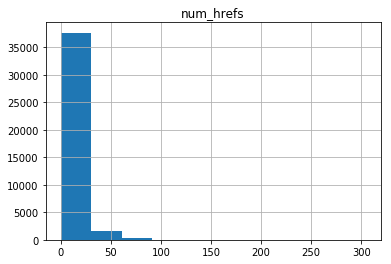

In [206]:
df[['num_hrefs']].hist()

Note that all of these features, are on different scales than our rate variables.

In [207]:
subset = df[df['num_hrefs'] < 40]

In [208]:
subset.shares.mean()

3348.5408500956614

In [209]:
subset = df[df['num_hrefs'] > 40]

In [210]:
subset.shares.mean()

5213.730643402399

This is a very big difference... Images with lots of shares seem to also have the most links in the articles. This can be explained based on how web crawlers look for links. 

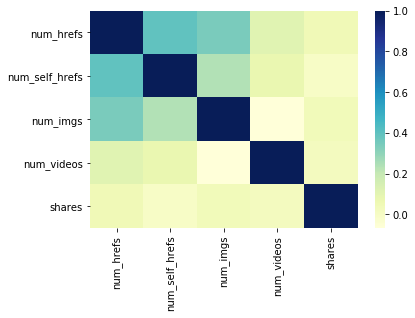

In [211]:
quant = df[['num_hrefs', 'num_self_hrefs', 'num_imgs', 'num_videos', 'shares']]

import seaborn as sns
corr = quant.corr()

sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        cmap="YlGnBu")

In [212]:
corr['shares']

num_hrefs         0.045404
num_self_hrefs   -0.001900
num_imgs          0.039388
num_videos        0.023936
shares            1.000000
Name: shares, dtype: float64

In spite of this though we see that our correlations with our target variable is low. 

We have a few more columns. 

19. kw_min_min: Worst keyword (min. shares)
20. kw_max_min: Worst keyword (max. shares)
21. kw_avg_min: Worst keyword (avg. shares)
22. kw_min_max: Best keyword (min. shares)
23. kw_max_max: Best keyword (max. shares)
24. kw_avg_max: Best keyword (avg. shares)
25. kw_min_avg: Avg. keyword (min. shares)
26. kw_max_avg: Avg. keyword (max. shares)
27. kw_avg_avg: Avg. keyword (avg. shares)

These columns were manufactured based on the number of shares each key word had. ex(kw_min_min is the minimum number of shares the least popular key word had) Let's look at these columns.

In [213]:
kw = df[['kw_min_min', 'kw_max_min', 'kw_avg_min',
       'kw_min_max', 'kw_max_max', 'kw_avg_max', 'kw_min_avg', 'kw_max_avg',
       'kw_avg_avg', 'shares']]

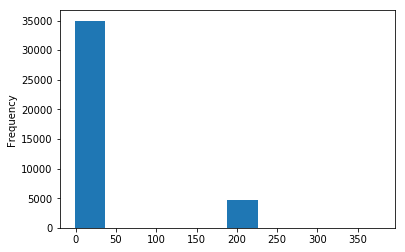

In [214]:
kw['kw_min_min'].plot.hist()

In [215]:
kw['kw_min_min'].value_counts()

-1.0      22980
 4.0      11908
 217.0     4636
 0.0         79
 47.0         6
 57.0         5
 86.0         4
 82.0         3
 63.0         2
 45.0         2
 129.0        2
 294.0        2
 88.0         2
 98.0         1
 162.0        1
 65.0         1
 184.0        1
 80.0         1
 318.0        1
 138.0        1
 201.0        1
 97.0         1
 377.0        1
 42.0         1
 41.0         1
 116.0        1
Name: kw_min_min, dtype: int64

The overwhelming majority of this class has a value of -1 and the rest 4 and 217. I think the min and max column aren't so useful for us since we already know our class has outliers.

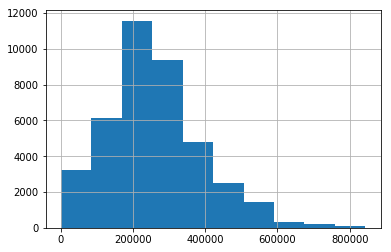

In [216]:
df['kw_avg_max'].hist()

kw avg max seems to be normally distributed with a slight right tail. This describes the average max number of shares per keyword. It's unclear if really all an article needs to become popular is one or 2 keywords or a high average. 

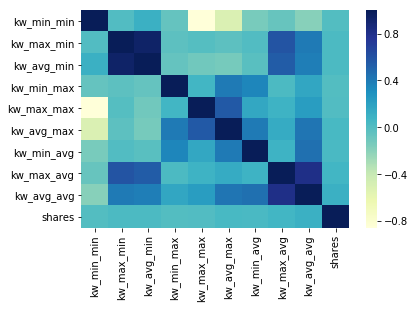

In [217]:

import seaborn as sns
corr = kw.corr()

sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        cmap="YlGnBu")

In [218]:
corr = kw.corr()
corr['shares']

kw_min_min   -0.001051
kw_max_min    0.030114
kw_avg_min    0.030406
kw_min_max    0.003901
kw_max_max    0.007863
kw_avg_max    0.044686
kw_min_avg    0.039551
kw_max_avg    0.064306
kw_avg_avg    0.110413
shares        1.000000
Name: shares, dtype: float64

We see here that only kw_avg_avg has an r^2 above .1. Again, the min and max columns logically don't really help us so much here just based on our distribution. These results all make sense. The more keywords an article has, the more shares. That's why all of these results are positive.

### EDA Wrapup...

1. We saw that our target variable shares is rightly skewed. 

2. There is no obvious correlation between many of our features and our target variable with a few exceptions....
    The more key words, the more shares a post has.
    Posts written on Saturday tend to have more shares. 
    We saw significant differences with the lda 3 and lda 2. columns - With lda 3 we saw high ldas have about 1000 more shares ad with lda 2 we saw high ldas have about 1000 less shares.
    The features number of links, videos and images, all resulted in higher shares when the amount was above a given cutoff.
    

### Data Preparation

We have a lot of features.
1. Some of our features we saw don't really impact our target variable.
2. Some of our numerical variables are on different scales. (ex - some are count variables like number of videos and others are scaled 0 to 1 to represent sentiment.)
3. We have Categorical Variables which need to be one hot encoded. (we have boolean dummy columns but we could eliminate 1 from each of the mutually exclusive columns) 

Let's first get rid of the features we saw we don't really need. 

In [219]:
df.columns

Index(['n_tokens_title', 'n_tokens_content', 'n_unique_tokens',
       'n_non_stop_words', 'n_non_stop_unique_tokens', 'num_hrefs',
       'num_self_hrefs', 'num_imgs', 'num_videos', 'average_token_length',
       'num_keywords', 'data_channel_is_lifestyle',
       'data_channel_is_entertainment', 'data_channel_is_bus',
       'data_channel_is_socmed', 'data_channel_is_tech',
       'data_channel_is_world', 'kw_min_min', 'kw_max_min', 'kw_avg_min',
       'kw_min_max', 'kw_max_max', 'kw_avg_max', 'kw_min_avg', 'kw_max_avg',
       'kw_avg_avg', 'self_reference_min_shares', 'self_reference_max_shares',
       'self_reference_avg_sharess', 'weekday_is_monday', 'weekday_is_tuesday',
       'weekday_is_wednesday', 'weekday_is_thursday', 'weekday_is_friday',
       'weekday_is_saturday', 'weekday_is_sunday', 'is_weekend', 'LDA_00',
       'LDA_01', 'LDA_02', 'LDA_03', 'LDA_04', 'global_subjectivity',
       'global_sentiment_polarity', 'global_rate_positive_words',
       'global_rate_negat

In [220]:
cleaned_1 = df.drop(['n_tokens_title','n_non_stop_unique_tokens','n_non_stop_words', 'kw_min_min', 'kw_max_min', 'kw_avg_min',
       'kw_min_max', 'kw_max_max', 'kw_avg_max', 'kw_min_avg', 'kw_max_avg', 'abs_title_subjectivity', 'abs_title_sentiment_polarity','max_positive_polarity',
       'min_negative_polarity', 'self_reference_min_shares',
       'self_reference_max_shares', 'max_negative_polarity','min_positive_polarity'
       ], axis = 1 )

I dorpped url since that is a key and timedelta since those are just used by the source system and aren't predictive. 'n_non_stop_unique_tokens' was dropped since it is highly correlated to n_non_stop_words and its values are very close to 0. Of the kw columns I dropped all the columns except kw_avg_avg since that had the highest coeficent. I also dropped the 2 absolute value columns as that is tightly coupled to the variable it is taking the prediction of and I will be scaling our variable. I also dropped the min and max negative polarity rate as that is more of a confidence interval. 

In [221]:
cleaned_1.columns

Index(['n_tokens_content', 'n_unique_tokens', 'num_hrefs', 'num_self_hrefs',
       'num_imgs', 'num_videos', 'average_token_length', 'num_keywords',
       'data_channel_is_lifestyle', 'data_channel_is_entertainment',
       'data_channel_is_bus', 'data_channel_is_socmed', 'data_channel_is_tech',
       'data_channel_is_world', 'kw_avg_avg', 'self_reference_avg_sharess',
       'weekday_is_monday', 'weekday_is_tuesday', 'weekday_is_wednesday',
       'weekday_is_thursday', 'weekday_is_friday', 'weekday_is_saturday',
       'weekday_is_sunday', 'is_weekend', 'LDA_00', 'LDA_01', 'LDA_02',
       'LDA_03', 'LDA_04', 'global_subjectivity', 'global_sentiment_polarity',
       'global_rate_positive_words', 'global_rate_negative_words',
       'rate_positive_words', 'rate_negative_words', 'avg_positive_polarity',
       'avg_negative_polarity', 'title_subjectivity',
       'title_sentiment_polarity', 'shares'],
      dtype='object')

Now we should also drop 1 of our weekday columns since if it is not one of the other 6 weekdays the model could pick up that it is on the 7th. This isn't true with the data_channel columns though which are also categorical since not all rows fit into one of those descriptions. 

In [222]:
cleaned_2 = cleaned_1.drop(['weekday_is_tuesday'], axis = 1)

In [223]:
cleaned_2.columns

Index(['n_tokens_content', 'n_unique_tokens', 'num_hrefs', 'num_self_hrefs',
       'num_imgs', 'num_videos', 'average_token_length', 'num_keywords',
       'data_channel_is_lifestyle', 'data_channel_is_entertainment',
       'data_channel_is_bus', 'data_channel_is_socmed', 'data_channel_is_tech',
       'data_channel_is_world', 'kw_avg_avg', 'self_reference_avg_sharess',
       'weekday_is_monday', 'weekday_is_wednesday', 'weekday_is_thursday',
       'weekday_is_friday', 'weekday_is_saturday', 'weekday_is_sunday',
       'is_weekend', 'LDA_00', 'LDA_01', 'LDA_02', 'LDA_03', 'LDA_04',
       'global_subjectivity', 'global_sentiment_polarity',
       'global_rate_positive_words', 'global_rate_negative_words',
       'rate_positive_words', 'rate_negative_words', 'avg_positive_polarity',
       'avg_negative_polarity', 'title_subjectivity',
       'title_sentiment_polarity', 'shares'],
      dtype='object')

Now let's scale all our numerical columns...

In [224]:
numColumns = ['n_tokens_content', 'n_unique_tokens', 'num_hrefs', 'num_self_hrefs',
       'num_imgs', 'num_videos', 'average_token_length', 'num_keywords',
       'data_channel_is_world', 'kw_avg_avg', 'self_reference_avg_sharess','LDA_00', 'LDA_01', 'LDA_02', 'LDA_03', 'LDA_04',
       'global_subjectivity', 'global_sentiment_polarity',
       'global_rate_positive_words', 'global_rate_negative_words',
       'rate_positive_words', 'rate_negative_words', 'avg_positive_polarity',
       'avg_negative_polarity', 'title_subjectivity',
       'title_sentiment_polarity']

In [225]:
from sklearn import preprocessing
mm_scaler = preprocessing.MinMaxScaler()
cleaned_2[numColumns]= mm_scaler.fit_transform(df[numColumns])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000022F80F87DD8>,
      dtype=object)

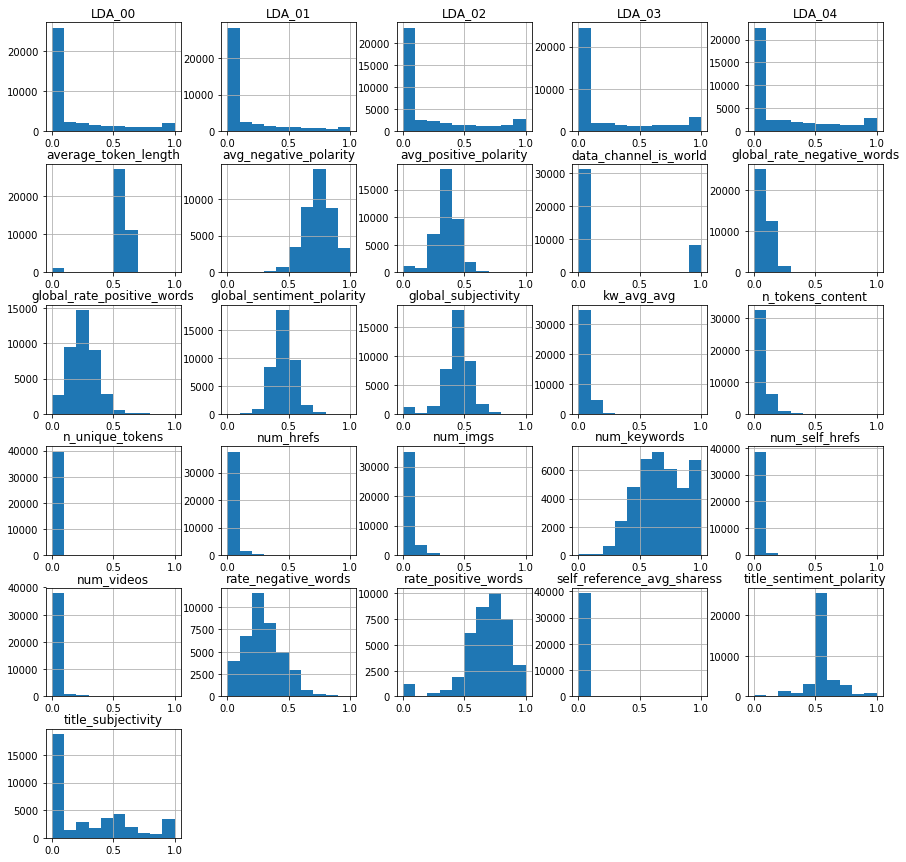

In [226]:
cleaned_2[numColumns].hist(figsize = (15,15))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000022F80798E48>,
      dtype=object)

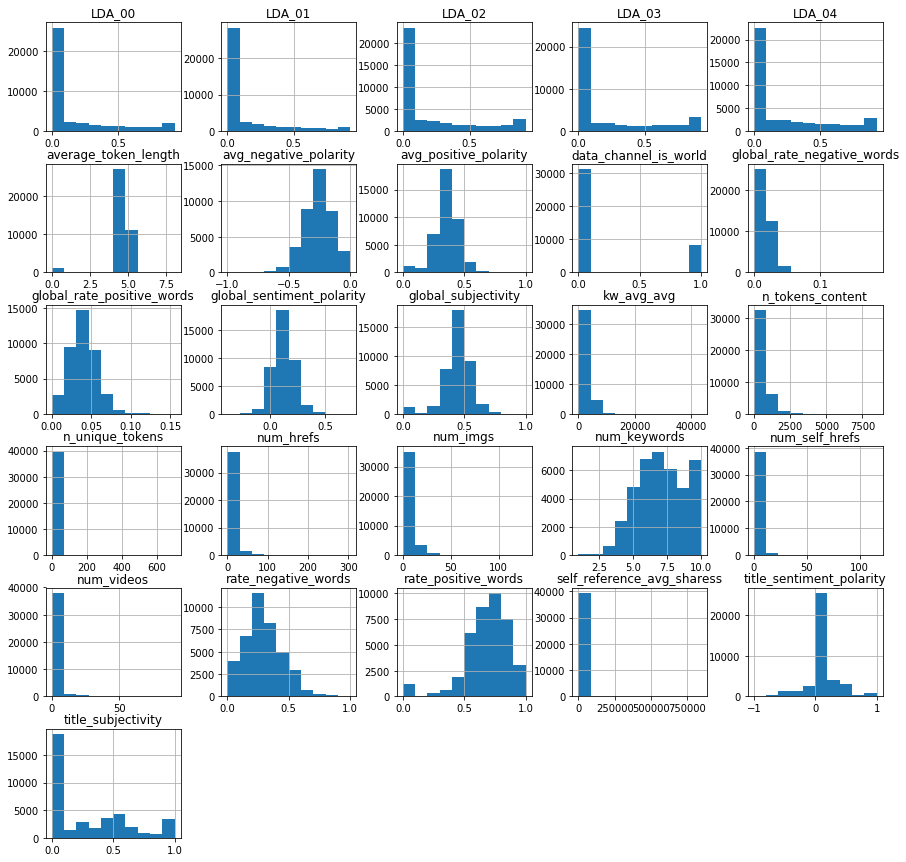

In [227]:
df[numColumns].hist(figsize = (15,15))

Our distributions all seem to be the same now...

I used min max scaling to preserve the outliers which are imporant as we are looking for trends in what makes articles very popular.

One slightly concerning issue though is that our sentiment column which was between -1 and 1 is now between 0 and 1. I think this is fine though - just above a certain value would be positive and below a certain value would be negative.

Another thing that I am noticing is that in some of our graphs we have outliers and that is causing a very high peak near zero. (ex - num_videos,)

In [228]:
df['num_videos'].max()

91.0

The maximum number of videos for example is 91. It is highly unlikely that a video would actually have 91 videos...

In [229]:
len(df[df['num_videos'] > 20])

575

There are a significant number of posts with above 20 videos. It is possible that there are certain types of posts which create more videos/links (ex - a slideshow). Because of this, I don't think we could just drop them. 

In [230]:
cleaned_2.columns

Index(['n_tokens_content', 'n_unique_tokens', 'num_hrefs', 'num_self_hrefs',
       'num_imgs', 'num_videos', 'average_token_length', 'num_keywords',
       'data_channel_is_lifestyle', 'data_channel_is_entertainment',
       'data_channel_is_bus', 'data_channel_is_socmed', 'data_channel_is_tech',
       'data_channel_is_world', 'kw_avg_avg', 'self_reference_avg_sharess',
       'weekday_is_monday', 'weekday_is_wednesday', 'weekday_is_thursday',
       'weekday_is_friday', 'weekday_is_saturday', 'weekday_is_sunday',
       'is_weekend', 'LDA_00', 'LDA_01', 'LDA_02', 'LDA_03', 'LDA_04',
       'global_subjectivity', 'global_sentiment_polarity',
       'global_rate_positive_words', 'global_rate_negative_words',
       'rate_positive_words', 'rate_negative_words', 'avg_positive_polarity',
       'avg_negative_polarity', 'title_subjectivity',
       'title_sentiment_polarity', 'shares'],
      dtype='object')

Let's create 2 new columns... the global_rate_positive_words - rate_positive_words  and the global_rate_negative_words - rate_negative words. This will allow us to condense these features.

In [231]:
cleaned_2['positive_rate_dif'] = cleaned_2['global_rate_positive_words'] - cleaned_2['rate_positive_words'] 

In [232]:
cleaned_2['negative_rate_dif'] = cleaned_2['global_rate_negative_words'] - cleaned_2['rate_negative_words'] 

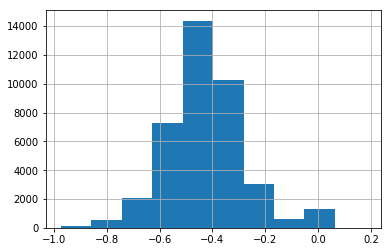

In [233]:
cleaned_2['positive_rate_dif'].hist()

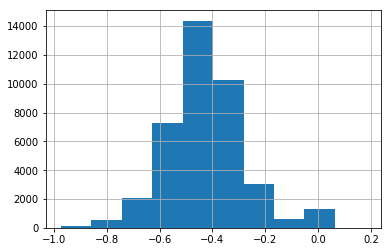

In [234]:
cleaned_2['positive_rate_dif'].hist()

I think it is fine to leave negative values - They have meaning. If it is negative it is below the global rate. 

With this, we can also drop the columns the features this is made up of in order to reduce the feature space. 

In [235]:
cleaned_3 = cleaned_2.drop(['global_rate_positive_words', 'global_rate_negative_words', 'rate_positive_words','rate_negative_words'], axis = 1)

Now we still have some columns that are not so predictive as we saw in our EDA work. The problem is that by using a deep learning model/forest we still might be able to pick up trends that we can't obviously find in our eda work. I think therefore that it is justifiable to keep them. We will be using the same variables for all of our models so that we could compare them except for our glm models since too many variables will skew the coefficients. 

### Metrics

Not all metrics apply to each type of model. For example, we only can get the aic score for our glm models. 
Because of this, let's define some common metrics we can use throughout each model. 

1. rmse - This defines the difference between the average of the squares of the error between the  predicted values and the actual values.
2. mape - This calculates the average error term in terms of a percentage. 
3. pdv - This is a custom metric that I think would be useful. It represents the percentage of samples that are within x * the the actual values. I think this metric would be useful because the scale of our data may make the rmse large just because there are outliers. For example, if a post actually had 1000 shares and our model predicted it had 20 shares that is an incorrect prediction. On the other hand if the actual number of shares was 4000 and we predicted 2000, that prediction is more correct than predicting 20 when it really had 1000 even though the residual is greater so we need a metric to capture this. We are interested in the overall trend and want to have an idea of how many of our points are being bucketed properly. I'm choosing not to use r2 because r2 will have bad performance here just since our data has a lot of variance that won't be able to be explained. We are missing key features like post history or how big the posters network is.

In [236]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

This metric is undefined when the actual value is 0. For our purposes this is fine as none of our actual predictions are 0 and a lot have hundreds of shares.

In [237]:
def pdv(actual,pred): 
    range_ = (pred > actual - (actual *.75)) & (pred < actual + actual * 1.25)
    return range_.sum()/len(actual)

This is just a metric we will use to see how many of our values are within this percentage of the true value. Mape tells us the avg and pdv will give us the percentage of values within a reasonable range.

### GLM Models

GLM models involve fitting a curve to predict the target variable.

In [238]:
import statsmodels.api as sm 
y = cleaned_3.shares
x = cleaned_3.drop('shares', axis = 1)

In [239]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)




As discussed earlier, our target variable is rightly skewed with a high variance. It also has few 0 records and is an integer.

Let's therefore start with a negative binomial. We will use backwords elimination to eliminate variables.

In [240]:
count_model = sm.GLM(y_train, sm.add_constant(X_train), family=sm.families.NegativeBinomial(sm.genmod.families.links.log)).fit()

C:\Users\b-coh\Anaconda3\lib\site-packages\numpy\linalg\linalg.py:1872: RuntimeWarning: invalid value encountered in greater
  return count_nonzero(S > tol, axis=-1)


In [241]:
count_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 shares   No. Observations:                31715
Model:                            GLM   Df Residuals:                    31715
Model Family:        NegativeBinomial   Df Model:                           -1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.8650e+05
Date:                Thu, 13 Aug 2020   Deviance:                       35288.
Time:                        00:25:17   Pearson chi2:                 2.35e+05
No. Iterations:                   100   Covariance Type:             nonrobust
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                          -356.5259     57.614     -6.188      0.000    -469.447    -243.604
n_tokens_content                  1.3338      0.155      8.586      0.000       1.029       1.638
n_unique_tokens                 365.6978     57.619      6.347      0.000     252.766     478.630
num_hrefs                         2.3219      0.190     12.223      0.000       1.950       2.694
num_self_hrefs                   -2.1377      0.196    -10.886      0.000      -2.523      -1.753
num_imgs                          0.6723      0.104      6.449      0.000       0.468       0.877
num_videos                        0.9177      0.135      6.807      0.000       0.653       1.182
average_token_length             -1.7651      0.121    -14.603      0.000      -2.002      -1.528
num_keywords                      0.2445      0.028      8.733      0.000       0.190       0.299
data_channel_is_lifestyle        -0.2248      0.038     -5.969      0.000      -0.299      -0.151
data_channel_is_entertainment    -0.4256      0.023    -18.359      0.000      -0.471      -0.380
data_channel_is_bus              -0.3866      0.036    -10.603      0.000      -0.458      -0.315
data_channel_is_socmed           -0.1193      0.035     -3.383      0.001      -0.188      -0.050
data_channel_is_tech             -0.1621      0.035     -4.569      0.000      -0.232      -0.093
data_channel_is_world            -0.2067      0.036     -5.795      0.000      -0.277      -0.137
kw_avg_avg                        6.8314      0.214     31.849      0.000       6.411       7.252
self_reference_avg_sharess        4.9726      0.208     23.943      0.000       4.566       5.380
weekday_is_monday                 0.1325      0.019      7.021      0.000       0.096       0.169
weekday_is_wednesday              0.0249      0.018      1.351      0.177      -0.011       0.061
weekday_is_thursday              -0.0233      0.019     -1.256      0.209      -0.060       0.013
weekday_is_friday                 0.0446      0.020      2.261      0.024       0.006       0.083
weekday_is_saturday               0.1237      0.017      7.183      0.000       0.090       0.157
weekday_is_sunday                 0.0097      0.017      0.579      0.563      -0.023       0.043
is_weekend                        0.1334      0.014      9.803      0.000       0.107       0.160
LDA_00                          337.7555     53.404      6.325      0.000     233.086     442.425
LDA_01                          337.2382     53.341      6.322      0.000     232.693     441.784
LDA_02                          334.6912     53.001      6.315      0.000     230.811     438.571
LDA_03                          337.5582     53.375      6.324      0.000     232.945     442.171
LDA_04                          337.6634     53.414      6.322      0.000     232.973     442.354
global_subjectivity       

At a first glance, we see that some of our variables are not so significant. (title_subjectivity, and is sunday with under .5) and a couple of others are around .2.

This isn't completely surprising as we saw above that Sunday had around 3700 which is near the average amount of shares. Likewise we didn't see that much of a difference with title subjectivity.

Another interesting point about our coefs are the LDA columns which are abnormally large compared to the other columns. 

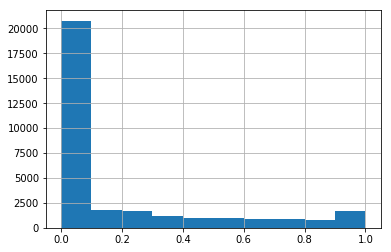

In [242]:
X_train.LDA_00.hist()

Perhaps the reason is because so many values are close to 0 and the model is giving these variables a lot of weight to compensate.
We saw above that some of the LDA columns had a significant variance with our target variable but not others.

The directions of our coefficients are also interesting to look at. Our constant was -356. Therefore the coefficients with large positive values increase the number of shares. 
Seemingly, the more unique words, the more popular the article is. This makes sense since the more unique words the more interesting the article would be. (note this is a proportion) 

Some of the negative signs though don't agree with our eda. For example, we saw that average_token_length did not change the number of shares yet here we see it has a negative coef. This makes sense though as longer words may make a more difficult read leading to less shares.

Some do make sense though. For example, Kw_avg_avg is also very high at around 6. This makes the most sense as we saw above that the higher average number of shares per keyword the more views.

In [243]:
preds = count_model.predict(sm.add_constant(X_train))

In [244]:
import sklearn.metrics as metrics
import numpy as np
np.sqrt(metrics.mean_squared_error(y_train,preds))


29483.937569326226

Our mse is around 29,000. This isn't very good all considering our variance. 

In [245]:
y_train.std()

11781.905899710917

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000022F9378E358>]],
      dtype=object)

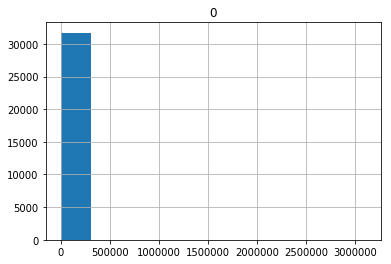

In [246]:
tmp = pd.DataFrame(preds)
tmp.hist()

Most of our predictions are low like our actual distribution. 

(0, 20000)

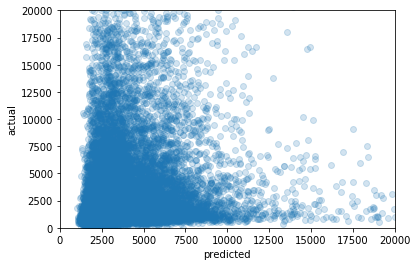

In [247]:
ax = plt.scatter(preds, y_train, alpha = .2)
plt.ylabel("actual")
plt.xlabel("predicted")
plt.xlim(0, 20000)
plt.ylim(0,20000)


Although it seems like the general direction of the graph is correct, we are underfitting values and we are not explaining most of the variance.

Let's try to remove some of the columns from our model - namely the number of words columns. They seem to have a large coeficent and unreasonably.

In [254]:
X_train.columns

Index(['n_tokens_content', 'n_unique_tokens', 'num_hrefs', 'num_self_hrefs',
       'num_imgs', 'num_videos', 'average_token_length', 'num_keywords',
       'data_channel_is_lifestyle', 'data_channel_is_entertainment',
       'data_channel_is_bus', 'data_channel_is_socmed', 'data_channel_is_tech',
       'data_channel_is_world', 'kw_avg_avg', 'self_reference_avg_sharess',
       'weekday_is_monday', 'weekday_is_wednesday', 'weekday_is_thursday',
       'weekday_is_friday', 'weekday_is_saturday', 'weekday_is_sunday',
       'is_weekend', 'LDA_00', 'LDA_01', 'LDA_02', 'LDA_03', 'LDA_04',
       'global_subjectivity', 'global_sentiment_polarity',
       'avg_positive_polarity', 'avg_negative_polarity', 'title_subjectivity',
       'title_sentiment_polarity', 'positive_rate_dif', 'negative_rate_dif'],
      dtype='object')

In [255]:
newSet = X_train.drop(['n_tokens_content', 'n_unique_tokens','title_subjectivity'], axis = 1 )

In [256]:
count_model = sm.GLM(y_train, sm.add_constant(newSet), family=sm.families.NegativeBinomial(sm.genmod.families.links.log)).fit()

In [257]:
count_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 shares   No. Observations:                31715
Model:                            GLM   Df Residuals:                    31682
Model Family:        NegativeBinomial   Df Model:                           32
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.8654e+05
Date:                Thu, 13 Aug 2020   Deviance:                       35369.
Time:                        00:28:55   Pearson chi2:                 2.43e+05
No. Iterations:                   100   Covariance Type:             nonrobust
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                             9.1707      1.005      9.125      0.000       7.201      11.140
num_hrefs                         2.5865      0.180     14.340      0.000       2.233       2.940
num_self_hrefs                   -1.9768      0.195    -10.141      0.000      -2.359      -1.595
num_imgs                          0.6361      0.097      6.541      0.000       0.445       0.827
num_videos                        1.0839      0.133      8.154      0.000       0.823       1.344
average_token_length             -1.3581      0.098    -13.879      0.000      -1.550      -1.166
num_keywords                      0.2477      0.028      8.854      0.000       0.193       0.303
data_channel_is_lifestyle        -0.2049      0.038     -5.461      0.000      -0.279      -0.131
data_channel_is_entertainment    -0.4084      0.023    -17.891      0.000      -0.453      -0.364
data_channel_is_bus              -0.3778      0.036    -10.397      0.000      -0.449      -0.307
data_channel_is_socmed           -0.1095      0.035     -3.115      0.002      -0.178      -0.041
data_channel_is_tech             -0.1430      0.035     -4.047      0.000      -0.212      -0.074
data_channel_is_world            -0.1964      0.035     -5.536      0.000      -0.266      -0.127
kw_avg_avg                        6.7384      0.214     31.438      0.000       6.318       7.159
self_reference_avg_sharess        4.9766      0.208     23.966      0.000       4.570       5.384
weekday_is_monday                 0.1288      0.019      6.824      0.000       0.092       0.166
weekday_is_wednesday              0.0295      0.018      1.602      0.109      -0.007       0.066
weekday_is_thursday              -0.0264      0.019     -1.428      0.153      -0.063       0.010
weekday_is_friday                 0.0461      0.020      2.339      0.019       0.007       0.085
weekday_is_saturday               0.1201      0.017      6.978      0.000       0.086       0.154
weekday_is_sunday                 0.0122      0.017      0.730      0.465      -0.021       0.045
is_weekend                        0.1324      0.014      9.729      0.000       0.106       0.159
LDA_00                           -1.1796      0.930     -1.269      0.205      -3.002       0.643
LDA_01                           -1.3058      0.928     -1.407      0.159      -3.125       0.513
LDA_02                           -1.7072      0.923     -1.851      0.064      -3.515       0.101
LDA_03                           -1.2360      0.929     -1.331      0.183      -3.056       0.584
LDA_04                           -1.3645      0.930     -1.467      0.142      -3.187       0.458
global_subjectivity               1.0436      0.077     13.547      0.000       0.893       1.195
global_sentiment_polarity         0.2428      0.145      1.677      0.094      -0.041       0.527
avg_positive_polarity     

In [258]:
preds = count_model.predict(sm.add_constant(newSet))

In [259]:
import numpy as np
np.sqrt(metrics.mean_squared_error(y_train,preds))

28424.457830256837

Our rmse went down after removing these columns. They actually seem to be negatively effecting the model. Our log likelihood stayed around the same so this doesn't seem so significant. 

The coeficents though dramatically changed though. Our constant is not positive and we see now all the LDA columns are actually negative.
    

The coeficents that stayed positive through this change indicate that these features are increasing the number of shares. 

For example, num hrefs is positive as the number of links increases the page visibility. Similarly, the positive number of videos and images indicate that they increase the number of shares. 
On the other hand, when the model has polarity, that is, coming across as strong, the article has less shares. Articles that are less polar actually seem to have more shares.

Let's remove the last few columns that are not significant. The goal of this is to try to optimize our model by needing less features and also make it easier to interpret the coefficients.

In [260]:
newSet = newSet.drop(['weekday_is_friday', 'global_sentiment_polarity' ], axis = 1 )

In [261]:
newSet = newSet.drop(['weekday_is_sunday'], axis = 1 )

In [262]:
count_model = sm.GLM(y_train, sm.add_constant(newSet), family=sm.families.NegativeBinomial(sm.genmod.families.links.log)).fit()

In [263]:
preds = count_model.predict(sm.add_constant(newSet))

In [264]:
np.sqrt(metrics.mean_squared_error(y_train,preds))

28029.586086213567

In [265]:
count_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 shares   No. Observations:                31715
Model:                            GLM   Df Residuals:                    31684
Model Family:        NegativeBinomial   Df Model:                           30
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.8654e+05
Date:                Thu, 13 Aug 2020   Deviance:                       35378.
Time:                        00:29:07   Pearson chi2:                 2.43e+05
No. Iterations:                    28   Covariance Type:             nonrobust
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                             9.2116      1.005      9.168      0.000       7.242      11.181
num_hrefs                         2.6129      0.180     14.505      0.000       2.260       2.966
num_self_hrefs                   -1.9803      0.195    -10.160      0.000      -2.362      -1.598
num_imgs                          0.6230      0.097      6.408      0.000       0.432       0.814
num_videos                        1.0630      0.132      8.025      0.000       0.803       1.323
average_token_length             -1.3447      0.098    -13.779      0.000      -1.536      -1.153
num_keywords                      0.2480      0.028      8.865      0.000       0.193       0.303
data_channel_is_lifestyle        -0.2051      0.038     -5.467      0.000      -0.279      -0.132
data_channel_is_entertainment    -0.4099      0.023    -17.955      0.000      -0.455      -0.365
data_channel_is_bus              -0.3810      0.036    -10.486      0.000      -0.452      -0.310
data_channel_is_socmed           -0.1105      0.035     -3.146      0.002      -0.179      -0.042
data_channel_is_tech             -0.1438      0.035     -4.070      0.000      -0.213      -0.075
data_channel_is_world            -0.1982      0.035     -5.589      0.000      -0.268      -0.129
kw_avg_avg                        6.7073      0.214     31.295      0.000       6.287       7.127
self_reference_avg_sharess        4.9671      0.208     23.921      0.000       4.560       5.374
weekday_is_monday                 0.1081      0.017      6.436      0.000       0.075       0.141
weekday_is_wednesday              0.0098      0.016      0.602      0.547      -0.022       0.042
weekday_is_thursday              -0.0465      0.016     -2.838      0.005      -0.079      -0.014
weekday_is_saturday               0.1069      0.031      3.433      0.001       0.046       0.168
is_weekend                        0.1249      0.024      5.269      0.000       0.078       0.171
LDA_00                           -1.1565      0.930     -1.244      0.214      -2.979       0.666
LDA_01                           -1.2845      0.928     -1.384      0.166      -3.103       0.535
LDA_02                           -1.6862      0.923     -1.828      0.068      -3.494       0.122
LDA_03                           -1.2143      0.929     -1.308      0.191      -3.035       0.606
LDA_04                           -1.3455      0.930     -1.447      0.148      -3.168       0.477
global_subjectivity               1.0659      0.076     13.966      0.000       0.916       1.215
avg_positive_polarity            -0.3481      0.073     -4.746      0.000      -0.492      -0.204
avg_negative_polarity            -0.2342      0.053     -4.417      0.000      -0.338      -0.130
title_sentiment_polarity          0.1479      0.043      3.421      0.001       0.063       0.233
positive_rate_dif         

We see now our lda columns are not significant.

In [266]:
newSet = newSet.drop(['LDA_00','LDA_01','LDA_02','LDA_03','LDA_04','LDA_00'], axis = 1 )

In [267]:
newSet = newSet.drop(['weekday_is_wednesday'], axis = 1 )

In [268]:
count_model = sm.GLM(y_train, sm.add_constant(newSet), family=sm.families.NegativeBinomial(sm.genmod.families.links.log)).fit()
count_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 shares   No. Observations:                31715
Model:                            GLM   Df Residuals:                    31690
Model Family:        NegativeBinomial   Df Model:                           24
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.8664e+05
Date:                Thu, 13 Aug 2020   Deviance:                       35569.
Time:                        00:29:12   Pearson chi2:                 2.50e+05
No. Iterations:                    29   Covariance Type:             nonrobust
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                             7.8222      0.072    108.977      0.000       7.682       7.963
num_hrefs                         2.6667      0.179     14.857      0.000       2.315       3.018
num_self_hrefs                   -1.9791      0.194    -10.177      0.000      -2.360      -1.598
num_imgs                          0.6329      0.097      6.545      0.000       0.443       0.822
num_videos                        1.1452      0.130      8.789      0.000       0.890       1.401
average_token_length             -1.4172      0.097    -14.678      0.000      -1.606      -1.228
num_keywords                      0.2650      0.028      9.507      0.000       0.210       0.320
data_channel_is_lifestyle        -0.2507      0.029     -8.580      0.000      -0.308      -0.193
data_channel_is_entertainment    -0.4239      0.021    -20.344      0.000      -0.465      -0.383
data_channel_is_bus              -0.3294      0.023    -14.417      0.000      -0.374      -0.285
data_channel_is_socmed           -0.1352      0.029     -4.706      0.000      -0.191      -0.079
data_channel_is_tech             -0.2216      0.022     -9.962      0.000      -0.265      -0.178
data_channel_is_world            -0.4676      0.023    -20.642      0.000      -0.512      -0.423
kw_avg_avg                        7.2878      0.211     34.540      0.000       6.874       7.701
self_reference_avg_sharess        5.0789      0.208     24.460      0.000       4.672       5.486
weekday_is_monday                 0.1095      0.016      6.962      0.000       0.079       0.140
weekday_is_thursday              -0.0461      0.015     -3.017      0.003      -0.076      -0.016
weekday_is_saturday               0.0999      0.031      3.208      0.001       0.039       0.161
is_weekend                        0.1266      0.023      5.513      0.000       0.082       0.172
global_subjectivity               1.1035      0.076     14.529      0.000       0.955       1.252
avg_positive_polarity            -0.3165      0.073     -4.319      0.000      -0.460      -0.173
avg_negative_polarity            -0.2669      0.053     -5.038      0.000      -0.371      -0.163
title_sentiment_polarity          0.1561      0.043      3.611      0.000       0.071       0.241
positive_rate_dif                -0.3575      0.054     -6.611      0.000      -0.464      -0.252
negative_rate_dif                -0.1662      0.066     -2.537      0.011      -0.295      -0.038
=================================================================================================
"""

Our coefficients analysis from earlier is still relevant. All of these columns still have the same direction and around the same strength.

In [270]:
preds = count_model.predict(sm.add_constant(newSet))
np.sqrt(metrics.mean_squared_error(y_train,preds))

39417.82782901497

Our rmse though is now significantly higher. I think this still may be the better model choice since if the other variables are simply contributing due to chance it may not perform as well on new data.

Since our model has a high rmse we can look at other glm models. 

Our data sort of looks like a gamma distribution so let's see if that would fit our data better.

We use the log link to force it to be positive. 

In [271]:
model = sm.GLM(y_train, X_train, family=sm.families.Gamma(link = sm.genmod.families.links.log)).fit()

print(model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 shares   No. Observations:                31715
Model:                            GLM   Df Residuals:                    31680
Model Family:                   Gamma   Df Model:                           34
Link Function:                    log   Scale:                          7.4184
Method:                          IRLS   Log-Likelihood:            -3.1388e+05
Date:                Thu, 13 Aug 2020   Deviance:                       35340.
Time:                        00:30:50   Pearson chi2:                 2.35e+05
No. Iterations:                   100   Covariance Type:             nonrobust
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
n_tokens_content                  0.7526      0.339      2.221      0.026       0.088       1

In [272]:
preds = count_model.predict(sm.add_constant(newSet))
np.sqrt(metrics.mean_squared_error(y_train,preds))

39417.82782901497

This model even with all the variables seems to be doing worse than the previous regression we tried. The log likelyhood is lower and the rmse is higher.

Another approach we can try is to try to predict the log of our target variable.

In [273]:
import math
logy = np.log(y_train)

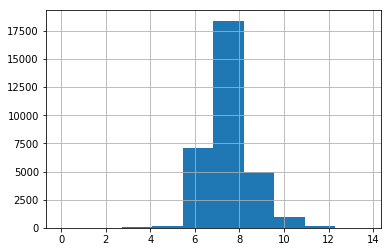

In [274]:
logy.hist()

By taking the log, we in essense normalized our target variable. 

In [275]:
model = sm.GLM(logy, sm.add_constant(newSet), family=sm.families.NegativeBinomial()).fit()

C:\Users\b-coh\Anaconda3\lib\site-packages\numpy\linalg\linalg.py:1872: RuntimeWarning: invalid value encountered in greater
  return count_nonzero(S > tol, axis=-1)


In [276]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 shares   No. Observations:                31715
Model:                            GLM   Df Residuals:                    31715
Model Family:        NegativeBinomial   Df Model:                           -1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -97529.
Date:                Thu, 13 Aug 2020   Deviance:                       372.92
Time:                        00:31:04   Pearson chi2:                     385.
No. Iterations:                     5   Covariance Type:             nonrobust
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                             1.9746      0.076     25.870      0.000       1.825       2.124
num_hrefs                         0.2195      0.191      1.151      0.250      -0.154       0.593
num_self_hrefs                   -0.1465      0.207     -0.708      0.479      -0.552       0.259
num_imgs                          0.0783      0.103      0.762      0.446      -0.123       0.280
num_videos                        0.0468      0.139      0.338      0.735      -0.225       0.318
average_token_length             -0.0927      0.103     -0.902      0.367      -0.294       0.109
num_keywords                      0.0209      0.030      0.704      0.482      -0.037       0.079
data_channel_is_lifestyle        -0.0079      0.031     -0.253      0.800      -0.069       0.053
data_channel_is_entertainment    -0.0379      0.022     -1.711      0.087      -0.081       0.006
data_channel_is_bus              -0.0119      0.024     -0.489      0.625      -0.059       0.036
data_channel_is_socmed            0.0270      0.031      0.886      0.376      -0.033       0.087
data_channel_is_tech              0.0096      0.024      0.407      0.684      -0.037       0.056
data_channel_is_world            -0.0356      0.024     -1.477      0.140      -0.083       0.012
kw_avg_avg                        0.5880      0.223      2.637      0.008       0.151       1.025
self_reference_avg_sharess        0.2391      0.219      1.090      0.276      -0.191       0.669
weekday_is_monday                 0.0065      0.017      0.389      0.697      -0.026       0.039
weekday_is_thursday              -0.0020      0.016     -0.121      0.904      -0.034       0.030
weekday_is_saturday               0.0012      0.033      0.037      0.971      -0.064       0.066
is_weekend                        0.0360      0.024      1.477      0.140      -0.012       0.084
global_subjectivity               0.0762      0.081      0.943      0.346      -0.082       0.235
avg_positive_polarity            -0.0180      0.078     -0.231      0.817      -0.171       0.135
avg_negative_polarity            -0.0182      0.056     -0.323      0.746      -0.129       0.092
title_sentiment_polarity          0.0220      0.046      0.477      0.633      -0.068       0.112
positive_rate_dif                -0.0111      0.058     -0.193      0.847      -0.124       0.102
negative_rate_dif                -0.0016      0.070     -0.023      0.981      -0.138       0.135
=================================================================================================
"""

Our mse is lower but to evaluate it we have to reverse the log by exponentiating.

In [277]:
preds = model.predict(sm.add_constant(newSet))

In [278]:
preds = np.exp(preds)

In [279]:
np.sqrt(metrics.mean_squared_error(y_train,preds))

12396.809593696686

We were able to cut our mse by about a 3rd by taking the log. Let's look at what the graph looks like.

Text(0.5, 0, 'predicted')

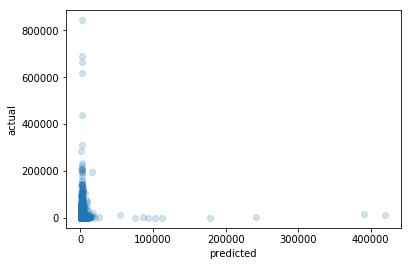

In [280]:
ax = plt.scatter(preds, y_train, alpha = .2)
plt.ylabel("actual")
plt.xlabel("predicted")


We have a few points we are predicting completly wrong but let's zoom in to see if the general trend is correct.

(0, 20000)

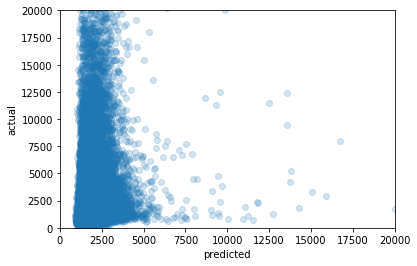

In [281]:
ax = plt.scatter(preds, y_train, alpha = .2)
plt.ylabel("actual")
plt.xlabel("predicted")
plt.xlim(0, 20000)
plt.ylim(0,20000)

We seem to be under predicting almost every point.

Compare this graph to our last negative binomial model.

In [282]:
count_model = sm.GLM(y_train, sm.add_constant(newSet), family=sm.families.NegativeBinomial(sm.genmod.families.links.log)).fit()

C:\Users\b-coh\Anaconda3\lib\site-packages\numpy\linalg\linalg.py:1872: RuntimeWarning: invalid value encountered in greater
  return count_nonzero(S > tol, axis=-1)


In [283]:
preds = count_model.predict(sm.add_constant(newSet))

(0, 20000)

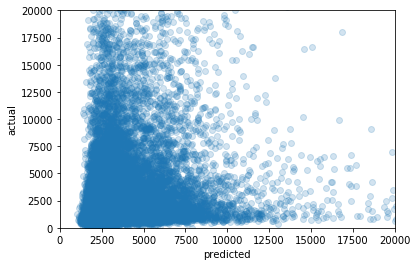

In [284]:
ax = plt.scatter(preds, y_train, alpha = .2)
plt.ylabel("actual")
plt.xlabel("predicted")
plt.xlim(0, 20000)
plt.ylim(0,20000)

This model is giving more higher predictions. In some respects this model is worse because we are giving high predictions low value but at the same time I don't like the log model because it is giving almost the same prediction to every point.

I do not think we should use a Poisson Distribution here because our data clearly has a very large variance that is not equal to the mean.

The main takeaway from this section should be our coefficient analysis. GLM models are going to be the easiest model we have to interpret the importance of our features and direction. For the most part, we saw that our coefficients agree with our eda. We saw that the number of keywords, videos, and images increase the number of shares.

Let's get all the stats to compare against future models. We will use the negative binomial model with all the features being significant. 

In [285]:
print(f"rmse {np.sqrt(metrics.mean_squared_error(y_train,preds))}")
print(f"mape: {mape(y_train,preds)}")
print(f"pdv: {pdv(y_train, preds)}")

rmse 39417.82782901497
mape: 238.27348730733732
pdv: 0.5475011824058017


We see this model has an mse of 39,417, and mape is 238. 54 percent of the values are within the 50 percent of the actual value.

### Random Forest.

One issue with glm models is that it can't model based off of decisions. For example, it might be true that the number of videos overall increase the number of shares but perhaps that is only true up to a certain number. Perhaps there is a certain threshold like if the number of videos is above 10 the number of shares decreases. For this reason we can reason that a decision tree/ forest would perform better.

A random forest is an ensemble method of individual decision trees.

We therefore might start by looking at how a single individual tree does.

In [252]:
from sklearn.tree import DecisionTreeRegressor
import numpy as np
rf = DecisionTreeRegressor()
rf.fit(X_train, y_train)
preds = rf.predict(X_train)

In [253]:
np.sqrt(metrics.mean_squared_error(y_train,preds))

0.0

The mean squared error is 0. This clearly shows we are overfitting. To compensate for this, we need to increase regularization. We could do this by setting a max depth.

In [254]:
rf = DecisionTreeRegressor(max_depth = 6)
rf.fit(X_train, y_train)
preds = rf.predict(X_train)

In [255]:
np.sqrt(metrics.mean_squared_error(y_train,preds))

9632.520061854571

Now our mse is lower but it's still high. We should use cross validation to evaluate our score,

In [256]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(rf, X_train, y_train, cv=5, scoring = 'neg_mean_squared_error')
np.sqrt(scores * -1) #broadcast the array

array([16559.03476958, 13115.43538643, 16537.11691837, 21087.93002208,
       13988.87080332])

There seems to be a large variance. The lowest score is 11300 and the highest is about 2x as much

We could further minimize this with grid search but instead we are going to construct a random forest, an ensemble of trees to help minimize this.

In [92]:
from sklearn.ensemble import RandomForestRegressor


In [286]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100, oob_score=True, random_state=123456)
rf.fit(X_train, y_train)

RandomForestRegressor(oob_score=True, random_state=123456)

In [258]:
preds = rf.predict(X_train)

In [259]:
np.sqrt(metrics.mean_squared_error(y_train,preds))

4565.637254315016

Our rmse is low but we need to make sure we aren't overfitting like we saw our trees were. 

In [260]:
scores = cross_val_score(rf, X_train, y_train, cv=5, scoring = 'neg_mean_squared_error')
np.sqrt(scores * -1) #broadcast the array

array([16471.47040891,  9808.43621882,  8151.87797862, 15807.17828265,
        8629.46885703])

Our cross val scores have high deviation like the tree model. We could try to correct for this by changing the depth of the tree.

The best way to find the best scores is with grid search

In [86]:
params = {
 'max_depth': [10, 40, 80, 100, None], # These parameters change when to split and how far down to go to prevent overfitting
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10]
}

In [87]:
from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(estimator = rf, param_grid = params, 
                          cv = 3, n_jobs = -1, verbose = 3) # only using c = 3 just because my computer can't use more 
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 45 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 65.0min
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed: 73.4min finished


{'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10}

We see the best parameters are with a max_depth of 10, 4 sample leaves, and a min_samples_split of 10.

In [97]:
rf = RandomForestRegressor(max_depth = 10, min_samples_leaf = 4, min_samples_split = 10, random_state=123456)
rf.fit(X_train, y_train)
preds = rf.predict(X_train)

In [115]:
df = pd.DataFrame(rf.feature_importances_)
df.index = X_train.columns
df[df.columns[0]].sort_values()

data_channel_is_tech             0.000150
weekday_is_sunday                0.000206
data_channel_is_world            0.000407
data_channel_is_socmed           0.000462
weekday_is_wednesday             0.001254
data_channel_is_lifestyle        0.001263
weekday_is_friday                0.001275
weekday_is_monday                0.002063
weekday_is_saturday              0.002338
weekday_is_thursday              0.002443
data_channel_is_entertainment    0.002762
num_keywords                     0.003111
is_weekend                       0.003799
data_channel_is_bus              0.011965
num_videos                       0.015695
num_self_hrefs                   0.018152
num_imgs                         0.020416
global_sentiment_polarity        0.021805
negative_rate_dif                0.023706
avg_negative_polarity            0.024887
title_sentiment_polarity         0.026620
positive_rate_dif                0.027286
avg_positive_polarity            0.031050
LDA_04                           0

The number of shares per avg key word has the highest feature importance. This is consistent with our eda work and makes a lot of sense.

In [ ]:
preds.shape

Text(0.5, 0, 'predicted')

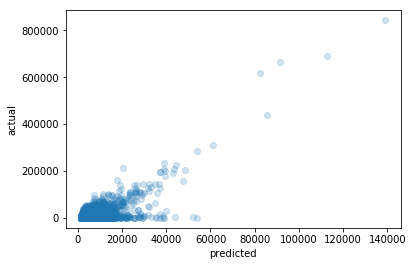

In [89]:
ax = plt.scatter(preds, y_train, alpha = .2)
plt.ylabel("actual")
plt.xlabel("predicted")


We see that our scores are in general going in the right direction. We are however underestimating the values though. 

Let's get all the scores so that we can compare our models.

In [91]:
import sklearn.metrics as metrics

print(np.sqrt(metrics.mean_squared_error(y_train,preds)))
print(mape(y_train,preds))
print(pdv(y_train, preds))

10054.50558252644
180.45705434065283
0.5885858426612013


Overall these numbers are better than what we saw in model 1.

### MLP Regressor

In this section we will be constructing mlp regressors. This is a deep learning method. We will start with sklearn as a baseline and then use keras which gives more flexibility in choosing the number of layers.

In [261]:
from sklearn.neural_network import MLPRegressor

In [262]:
mlp = MLPRegressor(solver='adam', hidden_layer_sizes=10,
                           max_iter=1000, shuffle=False, random_state=9876,
                           activation='relu')

In [263]:
mlp.fit(X_train, y_train)


C:\Users\b-coh\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPRegressor(hidden_layer_sizes=10, max_iter=1000, random_state=9876,
             shuffle=False, solver='lbfgs')

In [264]:
preds = mlp.predict(X_train)

In [265]:
np.sqrt(metrics.mean_squared_error(y_train,preds))

11275.861388822432

In [266]:
mlp = MLPRegressor(solver='adam', hidden_layer_sizes=30,
                           max_iter=1000, shuffle=False, random_state=9876,
                           activation='relu', verbose = True)

In [267]:
mlp.fit(X_train, y_train)


Iteration 1, loss = 75212005.31305106
Iteration 2, loss = 75137495.11647072
Iteration 3, loss = 74996398.85085417
Iteration 4, loss = 74795611.41868968
Iteration 5, loss = 74543627.85683338
Iteration 6, loss = 74249620.93805902
Iteration 7, loss = 73923023.95184559
Iteration 8, loss = 73573157.56126572
Iteration 9, loss = 73208960.12886795
Iteration 10, loss = 72838790.70408213
Iteration 11, loss = 72470283.48104633
Iteration 12, loss = 72110239.81320566
Iteration 13, loss = 71764548.65775295
Iteration 14, loss = 71438129.53603841
Iteration 15, loss = 71134894.70936227
Iteration 16, loss = 70857730.01815379
Iteration 17, loss = 70608495.89606160
Iteration 18, loss = 70388051.93015181
Iteration 19, loss = 70196309.55596781
Iteration 20, loss = 70032317.30848245
Iteration 21, loss = 69894381.23989670
Iteration 22, loss = 69780218.87054752
Iteration 23, loss = 69687139.23502341
Iteration 24, loss = 69612234.15041924
Iteration 25, loss = 69552559.97482377
Iteration 26, loss = 69505253.0694

Iteration 211, loss = 68471654.26444051
Iteration 212, loss = 68470666.29758734
Iteration 213, loss = 68469693.18345268
Iteration 214, loss = 68468721.69229774
Iteration 215, loss = 68467774.51368843
Iteration 216, loss = 68466822.16763385
Iteration 217, loss = 68465886.88588749
Iteration 218, loss = 68464954.28994352
Iteration 219, loss = 68464027.24004443
Iteration 220, loss = 68463116.16435651
Iteration 221, loss = 68462206.16078894
Iteration 222, loss = 68461305.92894033
Iteration 223, loss = 68460412.65758938
Iteration 224, loss = 68459521.90429589
Iteration 225, loss = 68458645.41175401
Iteration 226, loss = 68457772.32639064
Iteration 227, loss = 68456906.62781455
Iteration 228, loss = 68456045.77187528
Iteration 229, loss = 68455190.94597843
Iteration 230, loss = 68454343.45436068
Iteration 231, loss = 68453499.21282621
Iteration 232, loss = 68452664.91191226
Iteration 233, loss = 68451835.50100929
Iteration 234, loss = 68451010.14283499
Iteration 235, loss = 68450191.11373678


Iteration 416, loss = 68342856.34227166
Iteration 417, loss = 68342343.06400597
Iteration 418, loss = 68341840.49535576
Iteration 419, loss = 68341339.13738748
Iteration 420, loss = 68340825.67717473
Iteration 421, loss = 68340331.87347977
Iteration 422, loss = 68339816.01537530
Iteration 423, loss = 68339320.85877989
Iteration 424, loss = 68338811.50855321
Iteration 425, loss = 68338308.47543162
Iteration 426, loss = 68337811.84479545
Iteration 427, loss = 68337299.74095342
Iteration 428, loss = 68336806.48652408
Iteration 429, loss = 68336296.92542796
Iteration 430, loss = 68335797.66202801
Iteration 431, loss = 68335303.36540496
Iteration 432, loss = 68334793.49035382
Iteration 433, loss = 68334302.09449187
Iteration 434, loss = 68333794.14989743
Iteration 435, loss = 68333296.82992470
Iteration 436, loss = 68332804.57655498
Iteration 437, loss = 68332297.44658230
Iteration 438, loss = 68331807.85110991
Iteration 439, loss = 68331300.76642941
Iteration 440, loss = 68330807.54415868


Iteration 623, loss = 68244704.42221238
Iteration 624, loss = 68244263.78476386
Iteration 625, loss = 68243803.53600951
Iteration 626, loss = 68243372.55906536
Iteration 627, loss = 68242911.10102408
Iteration 628, loss = 68242467.26894321
Iteration 629, loss = 68242036.51148938
Iteration 630, loss = 68241574.81626020
Iteration 631, loss = 68241142.11490335
Iteration 632, loss = 68240690.92021100
Iteration 633, loss = 68240243.98103879
Iteration 634, loss = 68239809.44331627
Iteration 635, loss = 68239353.87056847
Iteration 636, loss = 68238920.65642749
Iteration 637, loss = 68238463.43449689
Iteration 638, loss = 68238022.94011055
Iteration 639, loss = 68237597.09264232
Iteration 640, loss = 68237131.18212055
Iteration 641, loss = 68236704.04351211
Iteration 642, loss = 68236250.29235350
Iteration 643, loss = 68235809.46329115
Iteration 644, loss = 68235376.92431381
Iteration 645, loss = 68234925.18524030
Iteration 646, loss = 68234493.39375435
Iteration 647, loss = 68234044.23419207


Iteration 829, loss = 68158516.07187980
Iteration 830, loss = 68158119.39697367
Iteration 831, loss = 68157731.97130352
Iteration 832, loss = 68157352.96195498
Iteration 833, loss = 68156958.14833066
Iteration 834, loss = 68156592.82227887
Iteration 835, loss = 68156191.09983617
Iteration 836, loss = 68155815.70460565
Iteration 837, loss = 68155422.20944081
Iteration 838, loss = 68155043.18675721
Iteration 839, loss = 68154667.11285351
Iteration 840, loss = 68154269.33641815
Iteration 841, loss = 68153885.99958839
Iteration 842, loss = 68153520.01129329
Iteration 843, loss = 68153123.91537222
Iteration 844, loss = 68152751.08086009
Iteration 845, loss = 68152360.46049641
Iteration 846, loss = 68151995.57579052
Iteration 847, loss = 68151605.38822387
Iteration 848, loss = 68151223.94603059
Iteration 849, loss = 68150857.96672750
Iteration 850, loss = 68150465.70257735
Iteration 851, loss = 68150091.00756398
Iteration 852, loss = 68149724.41070837
Iteration 853, loss = 68149349.13663252


C:\Users\b-coh\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPRegressor(hidden_layer_sizes=30, max_iter=1000, random_state=9876,
             shuffle=False, verbose=True)

In [268]:
preds = mlp.predict(X_train)

In [269]:
np.sqrt(metrics.mean_squared_error(y_train,preds))

11670.150631525

Adding more node in each layer seems to have decreased our performace. 

Text(0.5, 0, 'predicted')

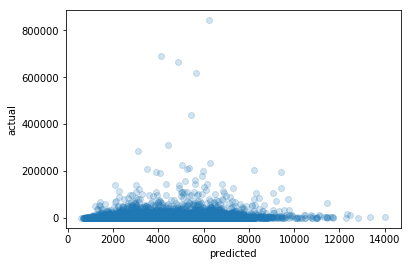

In [270]:
ax = plt.scatter(preds, y_train, alpha = .2)
plt.ylabel("actual")
plt.xlabel("predicted")

Let's use keras so we could try more values.

In [149]:
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.
C:\Users\b-coh\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\b-coh\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\b-coh\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\b-coh\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [147]:
def BuildModel(n_layers, nodes):
    model = Sequential()
    for i in range(n_layers):
        model.add(Dense(nodes, activation="relu"))
    model.add(Dense(1, activation="relu"))
    return model

In [277]:
regressor = BuildModel(5,128) #128 is the next highest power of 2 compared to the number of features so let's use that.
regressor.compile(loss="mean_squared_error", optimizer="adam")   


Instructions for updating:
Colocations handled automatically by placer.


In [280]:
regressor.fit(X_train.values,y_train.values, epochs = 30) 


Epoch 1/30
31715/31715 [==============================] - 2s 70us/step - loss: 137418258.9649
Epoch 2/30
31715/31715 [==============================] - 2s 70us/step - loss: 137096411.9763
Epoch 3/30
31715/31715 [==============================] - 2s 70us/step - loss: 137073606.6649
Epoch 4/30
31715/31715 [==============================] - 2s 70us/step - loss: 136919991.0791
Epoch 5/30
31715/31715 [==============================] - 2s 70us/step - loss: 136871252.1944:
Epoch 6/30
31715/31715 [==============================] - 2s 77us/step - loss: 136769891.3992
Epoch 7/30
31715/31715 [==============================] - 2s 74us/step - loss: 136641002.5465
Epoch 8/30
31715/31715 [==============================] - 2s 70us/step - loss: 136721731.3140
Epoch 9/30
31715/31715 [==============================] - 2s 70us/step - loss: 136457804.7024: 0s - loss: 14932140
Epoch 10/30
31715/31715 [==============================] - 2s 69us/step - loss: 136416154.1344
Epoch 11/30
31715/31715 [============

In [311]:
preds = regressor.predict(X_train)


In [304]:
preds.shape

(31715, 1)

In [312]:
preds = preds.reshape(-1)

In [313]:
preds.shape

(31715,)

In [314]:
print(np.sqrt(metrics.mean_squared_error(y_train,preds)))
print(mape(y_train,preds))
print(pdv(y_train, preds))

11472.863804271146
250.9894680262609
0.6245309790320038


The results above are almost identical to our sklearn model. We could try increasing the layers to see if that helps.

In [316]:
regressor = BuildModel(50,128) 
regressor.compile(loss="mean_squared_error", optimizer="adam")   

In [317]:
regressor.fit(X_train.values,y_train.values, epochs = 30)  

Epoch 1/30
31715/31715 [==============================] - 18s 560us/step - loss: 143476920.9094
Epoch 2/30
31715/31715 [==============================] - 14s 436us/step - loss: 139797920.0268
Epoch 3/30
31715/31715 [==============================] - 16s 494us/step - loss: 139417018.2580
Epoch 4/30
31715/31715 [==============================] - 18s 566us/step - loss: 139383047.8432
Epoch 5/30
31715/31715 [==============================] - 17s 533us/step - loss: 139160934.2181
Epoch 6/30
31715/31715 [==============================] - 17s 543us/step - loss: 139156030.5441
Epoch 7/30
31715/31715 [==============================] - 16s 498us/step - loss: 139080935.0636
Epoch 8/30
31715/31715 [==============================] - 16s 514us/step - loss: 139154689.9294
Epoch 9/30
31715/31715 [==============================] - 13s 422us/step - loss: 138989556.1610
Epoch 10/30
31715/31715 [==============================] - 13s 418us/step - loss: 139029451.7244
Epoch 11/30
31715/31715 [==============

In [318]:
preds = regressor.predict(X_train).reshape(-1)

In [319]:
print(np.sqrt(metrics.mean_squared_error(y_train,preds)))
print(mape(y_train,preds))
print(pdv(y_train, preds))

11803.618160349442
154.67063497738658
0.5796310893898786


This model has a better mape score but it's mse is worse and it takes longer to build. Let's try 1 layer.

In [321]:
regressor = BuildModel(1,128) 
regressor.compile(loss="mean_squared_error", optimizer="adam")   

In [322]:
regressor.fit(X_train.values,y_train.values, epochs = 30)  

Epoch 1/30
31715/31715 [==============================] - 3s 81us/step - loss: 148239803.7663
Epoch 2/30
31715/31715 [==============================] - 2s 55us/step - loss: 141615283.2141
Epoch 3/30
31715/31715 [==============================] - 2s 52us/step - loss: 139164625.8159
Epoch 4/30
31715/31715 [==============================] - 2s 56us/step - loss: 138743954.7469
Epoch 5/30
31715/31715 [==============================] - 2s 54us/step - loss: 138590789.7979
Epoch 6/30
31715/31715 [==============================] - 2s 53us/step - loss: 138466937.6284
Epoch 7/30
31715/31715 [==============================] - 2s 56us/step - loss: 138351541.3347
Epoch 8/30
31715/31715 [==============================] - 2s 52us/step - loss: 138249591.7439
Epoch 9/30
31715/31715 [==============================] - 2s 56us/step - loss: 138149808.4340
Epoch 10/30
31715/31715 [==============================] - 2s 56us/step - loss: 138053538.6687
Epoch 11/30
31715/31715 [==============================] - 

In [323]:
preds = regressor.predict(X_train).reshape(-1)
print(np.sqrt(metrics.mean_squared_error(y_train,preds)))
print(mape(y_train,preds))
print(pdv(y_train, preds))

11709.479514899807
197.59755196938698
0.5080561248620526


All of these scores are a bit worse than the model with 5 layers. We also should try varying the numberof nodes in each layer.

In [325]:
regressor = BuildModel(5,32)  # divide by a quarter
regressor.compile(loss="mean_squared_error", optimizer="adam")  

In [326]:
regressor.fit(X_train.values,y_train.values, epochs = 30)  

Epoch 1/30
31715/31715 [==============================] - 4s 113us/step - loss: 139580661.6164
Epoch 2/30
31715/31715 [==============================] - 2s 65us/step - loss: 137360092.5981
Epoch 3/30
31715/31715 [==============================] - 2s 64us/step - loss: 137111554.7470
Epoch 4/30
31715/31715 [==============================] - 2s 63us/step - loss: 137016528.8753: 0s - loss: 1
Epoch 5/30
31715/31715 [==============================] - 2s 65us/step - loss: 137023368.0142
Epoch 6/30
31715/31715 [==============================] - 2s 64us/step - loss: 136925918.1954
Epoch 7/30
31715/31715 [==============================] - 2s 61us/step - loss: 136905399.2214
Epoch 8/30
31715/31715 [==============================] - 2s 64us/step - loss: 136744542.6000
Epoch 9/30
31715/31715 [==============================] - 2s 63us/step - loss: 136710735.9715
Epoch 10/30
31715/31715 [==============================] - 2s 63us/step - loss: 136700275.7698
Epoch 11/30
31715/31715 [===================

In [327]:
preds = regressor.predict(X_train).reshape(-1)
print(np.sqrt(metrics.mean_squared_error(y_train,preds)))
print(mape(y_train,preds))
print(pdv(y_train, preds))

11658.03463498353
181.79402478745484
0.5750275894687057


| Model                       | rmse                            | Mape      | pdv
|-----------------------------|---------------------------------|-----------|---------
| BuildModel(5,128)          | 11472                        | 250     | 0.62          
| BuildModel(1,128)           | 11709.47951                 | 197.59    | 0.50    
| BuildModel(5,32)            | 11658                           | 181       | 0.57  


I think the model with 5 layers and 128 nodes is the best. It's MSE and pdv are the best of all the models which I think are the 2 most important metrics in gaging how many of the value we are predicting accurately.

We also should increase the number of epochs though since the score seems to still be slightly improving past 30.

In [150]:
regressor = BuildModel(5,128) #128 is the next highest power of 2 compared to the number of features so let's use that.
regressor.compile(loss="mean_squared_error", optimizer="adam")   
regressor.fit(X_train.values,y_train.values, epochs = 200)  

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/200
31715/31715 [==============================] - 3s 108us/step - loss: 138425636.0964
Epoch 2/200
31715/31715 [==============================] - 2s 69us/step - loss: 137342505.5361
Epoch 3/200
31715/31715 [==============================] - 2s 70us/step - loss: 137180612.5270
Epoch 4/200
31715/31715 [==============================] - 2s 71us/step - loss: 136972163.5090
Epoch 5/200
31715/31715 [==============================] - 2s 69us/step - loss: 136877899.2315
Epoch 6/200
31715/31715 [==============================] - 2s 71us/step - loss: 136792316.0401
Epoch 7/200
31715/31715 [==============================] - 2s 70us/step - loss: 136739779.3778
Epoch 8/200
31715/31715 [==============================] - 2s 71us/step - loss: 136490003.5103
Epoch 9/200
31715/31715 [==============================] - 2s 74us/step - loss: 136498027.3833
Epoch 10/200
31715/31715

31715/31715 [==============================] - 3s 87us/step - loss: 39556716.0972
Epoch 163/200
31715/31715 [==============================] - 3s 84us/step - loss: 44986621.5567 0s - loss:
Epoch 164/200
31715/31715 [==============================] - 3s 83us/step - loss: 59090654.4887
Epoch 165/200
31715/31715 [==============================] - 3s 84us/step - loss: 58802439.9796
Epoch 166/200
31715/31715 [==============================] - 3s 83us/step - loss: 49400891.2816 0s - loss:
Epoch 167/200
31715/31715 [==============================] - 3s 84us/step - loss: 56339636.1791
Epoch 168/200
31715/31715 [==============================] - 3s 102us/step - loss: 49169547.4500
Epoch 169/200
31715/31715 [==============================] - 3s 100us/step - loss: 49789360.1043
Epoch 170/200
31715/31715 [==============================] - 3s 109us/step - loss: 44324732.4399
Epoch 171/200
31715/31715 [==============================] - 3s 104us/step - loss: 41666711.3678
Epoch 172/200
31715/31715 [=

In [161]:
preds = regressor.predict(X_train).reshape(-1)
print(np.sqrt(metrics.mean_squared_error(y_train,preds)))
print(mape(y_train,preds))
print(pdv(y_train, preds))

5807.241526413612
160.12782104721896
0.6137789689421409


Text(0.5, 0, 'predicted')

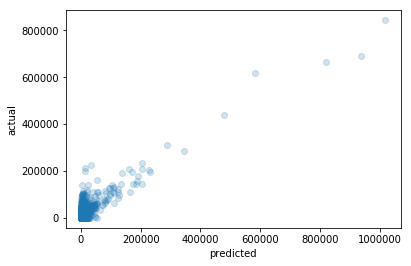

In [331]:
ax = plt.scatter(preds, y_train, alpha = .2)
plt.ylabel("actual")
plt.xlabel("predicted")

In general this model seems to be predicting the value in the general direction correctly. It's pdv score is slightly lower than the one with 30 epochs but the rmse is around half so overall this model is better. Increasing the epochs seems to significantly improve our score at the expense of time.

### XGBoosting Regression. 

XG Boosting combines multiple weak learners into a stronger learner. Certain parts can be done in parallel so it may perform faster.

In [289]:
from xgboost import XGBRegressor
model = XGBRegressor()
model.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [290]:
preds = model.predict(X_train)
math.sqrt(metrics.mean_squared_error(y_train, preds))


4457.5024807529835

In [291]:
preds = model.predict(X_train)


Text(0.5, 0, 'predicted')

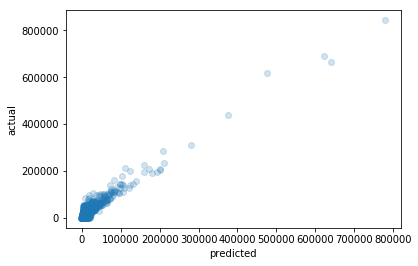

In [292]:
ax = plt.scatter(preds, y_train, alpha = .2)
plt.ylabel("actual")
plt.xlabel("predicted")

In [ ]:
scores = cross_val_score(model, X_train, y_train, cv=5, scoring = 'neg_mean_squared_error')
np.sqrt(scores * -1) 

We see that this model is heavily overfitting. We could try to compensate by changing the hyper parameters.

We should use grid search to find the optimum arguments. All of the ones we will look at aim at reducing overfitting.

In [98]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2),
 'gamma': [.01, .1, .001]
}
gs = GridSearchCV(estimator = model, param_grid = param_test1, scoring='neg_mean_squared_error',n_jobs=4, cv=3)
gs.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_para

In [100]:
gs.best_params_

{'gamma': 0.01, 'max_depth': 3, 'min_child_weight': 5}

In [151]:
model = XGBRegressor(max_depth = 3, gamma = .01,min_child_weight = 5  )
model.fit(X_train, y_train)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.01, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=3,
             min_child_weight=5, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [152]:
preds = model.predict(X_train)

Text(0.5, 0, 'predicted')

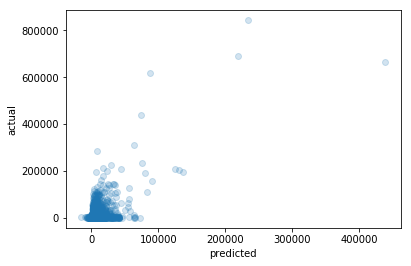

In [155]:
ax = plt.scatter(preds, y_train, alpha = .2)
plt.ylabel("actual")
plt.xlabel("predicted")

In [359]:
print(np.sqrt(metrics.mean_squared_error(y_train,preds)))
print(mape(y_train,preds))
print(pdv(y_train, preds))

9533.60826312351
182.04701791044494
0.6058647327762888


This model seems good but a concern is that we are predicting values below 0. This could be a problem since it doesn't make sense to have less than 0 shares.

In [107]:
df = pd.DataFrame(model.feature_importances_)
df.index = X_train.columns

In [113]:
df[df.columns[0]].sort_values()

weekday_is_sunday                0.000000
weekday_is_friday                0.000000
data_channel_is_lifestyle        0.000000
data_channel_is_socmed           0.000000
data_channel_is_tech             0.000000
data_channel_is_world            0.000000
is_weekend                       0.002652
num_keywords                     0.002784
weekday_is_thursday              0.003917
weekday_is_monday                0.004160
title_subjectivity               0.004304
weekday_is_saturday              0.010245
data_channel_is_entertainment    0.010867
avg_negative_polarity            0.020773
negative_rate_dif                0.020997
num_hrefs                        0.021226
self_reference_avg_sharess       0.025707
num_imgs                         0.026561
title_sentiment_polarity         0.028528
average_token_length             0.028752
LDA_02                           0.031106
global_subjectivity              0.031114
weekday_is_wednesday             0.034220
LDA_04                           0

It seems like most of these features aren't playing such a big role. The LDA columns have the highest importance but it is unclear why that would be as we didn't see anything significant with this column from our EDA. We did see that this had a large coefficients in the our first glm model though so perhaps there is in fact some relationship we couldn't find earlier. Again though, this is an engineered feature by another machine learning model. It is hard to directly interpret this.

### Ensemble 

We will use a stacking method to create our ensemble.

Steps

1. Train our 4 models. 
2. Create a model that learns how to weight these predictions. We can create an XGBoost Model to do this.

First let's create our 4 models from the best models we saw above.

In [154]:
model1 =  sm.GLM(y_train, sm.add_constant(newSet), family=sm.families.NegativeBinomial(sm.genmod.families.links.log)).fit()
print("trained")
model2 = RandomForestRegressor(n_estimators=100, max_depth = 12, oob_score=True, min_samples_split = 20, random_state=123456).fit(X_train,y_train)
print("trained")
model3 = regressor
print("trained")
model4 = model = XGBRegressor(max_depth = 3, gamma = .01,min_child_weight = 5  ).fit(X_train,y_train)


trained
trained
trained


In [ ]:
# X_train.drop(['ensemble'], axis = 1, inplace = True)

In [183]:
#predictions = [model1.predict(sm.add_constant(newSet)), model2.predict(X_train), model4.predict(X_train)]
predictions = [model1.predict(sm.add_constant(newSet)), model2.predict(X_train), model3.predict(X_train).reshape(-1), model4.predict(X_train)]
preds = pd.DataFrame(predictions).T

In [165]:
from sklearn.model_selection import GridSearchCV

param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2),
 'gamma': [.01, .1, .001]
}
gs = GridSearchCV(estimator =XGBRegressor(), param_grid = param_test1, scoring='neg_mean_squared_error',n_jobs=4, cv=3)
gs.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_para

In [166]:
gs.best_params_

{'gamma': 0.01, 'max_depth': 3, 'min_child_weight': 5}

In [168]:
ensemble_model = XGBRegressor(min_child_weight = 5, max_depth = 3, gamma = .01).fit(preds,y_train)

In [184]:
preds = ensemble_model.predict(preds)

In [185]:
print(np.sqrt(metrics.mean_squared_error(y_train,preds)))
print(mape(y_train,preds))
print(pdv(y_train, preds))

9992.747886231227
185.16371865728541
0.5858741920227022


Text(0.5, 0, 'predicted')

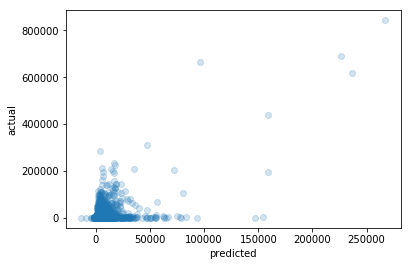

In [186]:
ax = plt.scatter(preds, y_train, alpha = .2)
plt.ylabel("actual")
plt.xlabel("predicted")

In [171]:
importance = pd.DataFrame(ensemble_model.feature_importances_)
importance.index = ['GLM', 'Forest', 'Neural Net', 'XGBoost']
importance

,0
GLM,0.222973
Forest,0.304802
Neural Net,0.147646
XGBoost,0.324579


I'm somewhat surprised that Neural Net has the lowest importance as it's predictions had the lowest rmse.

We will compare the ensemble in the next section.

### Model Comparison

| Model                       | rmse                            | Mape      | pdv
|-----------------------------|---------------------------------|-----------|---------
| GLM                         | 39417.82                        | 238.2     | 0.5475
| Random Forest               | 8504.88                         | 174.3     | 0.6079          
| Neural Net                  | 6291.91                         | 175       | 0.61    
| XG Boost                    | 9533                           | 182       | 0.605   
| Ensemble                    |  9992              | 185    | 0.58  

Our GLM model seems to be the worse. It has very low scores for all the metrics. XGBoost is much faster than the Neural Net and the Forest but it also predicted negative values so we can't really use that. Between the Neural Net and the Forest, I think the Forest is better even though it has a slightly higher rmse because it is less complex and we got visibility into what features were important.

The ensemble model did very similar to the XGBoost model. The overall goal of the ensemble was that although our models may have been weak, we may have been able to create another model that could see the weaknesses and make a new model over it that would be able to see where the model was predicting wrong values.

This didn't seem to occur. I think one reason why is just because our initial models were not that strong and there were no pattern in where the model was predicting bad values. If we knew for example that the random forest tended to low ball predictions and the neural net tended to high ball the predictions the meta learner would do well. We didn't have any pattern like this though. 

In [ ]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model2, X_train, y_train, cv=5, scoring = 'neg_mean_squared_error')
np.sqrt(scores * -1) #broadcast the array

We see that our model is not suffering from overfitting so we could proceed with applying it to the test data.

### Evaluate on Test Data

In [178]:
preds = model2.predict(X_test) #Model 2 is our forest.

In [179]:
print(np.sqrt(metrics.mean_squared_error(y_test,preds)))
print(mape(y_test,preds))
print(pdv(y_test, preds))

10964.57831757763
170.46180350750515
0.5729600201790894


Although our mse is slightly higher than our training set, the mape score is actually lower. They all are around the same though, showing that we aren't overfitting.

Text(0.5, 0, 'predicted')

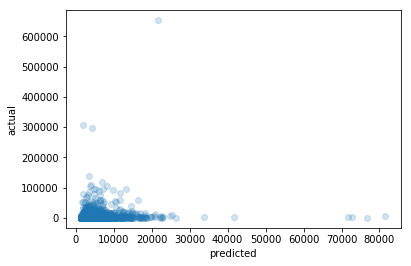

In [180]:
ax = plt.scatter(preds, y_test, alpha = .2)
plt.ylabel("actual")
plt.xlabel("predicted")

(0, 20000)

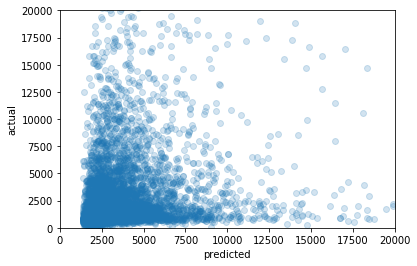

In [181]:
ax = plt.scatter(preds, y_test, alpha = .2)
plt.ylabel("actual")
plt.xlabel("predicted")
plt.xlim(0, 20000)
plt.ylim(0,20000)

Our residual graph shows some issues with the model. There is a very wide variance and some points we are predicting completely wrong.

As a whole though, we see from our pdv metric that we are getting more than half of our values within 50 percent of the true value. It is hard to tell from this graph because all the points tend to be clustered in the same area. 

#### Conclusions

1. There is no obvious correlation between metadata about an article and how many shares it has, apart from the key words feature. There were some small variations based on things like the day of the week the article was published but these differences weren't so pronounced. 
2. Our models were all able to predict over half the number of shares within 50 percent of the true value. 
3. The random forest was chosen as the best model because it had the 2nd to best metrics and wasn't as complex as a deep learning method. We saw from cross validation that it did not suffer from overfitting.
4. We saw that the number of key words played an important role in most of the models. We saw that the LDA columns, hrefs, and image columns also had large coefficients in our glm model showing that they were important. This is important practically because it is possible to have an article have more views by simply adding more key words or less obviously just more links. 

Note that one problem with our dataset was that we had no information about the author. Naturally, authors with larger networks would have more shares. This made it hard to always accurately predict the outlier columns as we see from the graph of the test data with the random forest. Future work should try to encompass these variables. 